In [1]:
# standard
import pandas as pd
import numpy as np

# fastai
from fastai.tabular import TabularDataBunch, tabular_learner, accuracy, FillMissing, Categorify, Normalize, ClassificationInterpretation, DatasetType, TabularList

# personal
from src.utils import dis_df, get_df_paths, calculate_age, get_df_dis, F_KEY, apply_cat, get_acc, plot_roc_curve, get_advanced_dis_df

# sklearn
from sklearn import tree, metrics
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# display
import matplotlib.pyplot as plt
from IPython.display import Image
import pydot

from fastai.callbacks import *
from fastai.metrics import roc_curve
from sklearn.metrics import auc

import radiomics
radiomics.__version__

/home/biomech/anaconda3/lib/python3.7/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


'v3.0'

## Get datasets without radiomics -> Only age, location and gender dependent

In [2]:
def get_exp_keys(mode, dis):
    exp = pd.read_csv(f'{PATH}/{mode}-except.csv')
    exp_keys = exp.keys()
    exp = [exp[key][0] for key in exp_keys][1::]
    
    arr = dis[mode]['idx']

    new_arr = []
    for ele in arr:
        if ele in exp:
            continue
        new_arr.append(ele)
    
    dis[mode]['idx'] = new_arr
    return dis

In [3]:
df, _ = get_df_paths()
dis = get_advanced_dis_df(df)

PATH = 'radiomics'
REM_KEYS = ['Unnamed: 0', 'label2']
DEP_KEY = 'label1'

train = pd.read_csv(f'{PATH}/train.csv')
valid = pd.read_csv(f'{PATH}/valid.csv')
test = pd.read_csv(f'{PATH}/test.csv')

train = train.fillna(0).drop(columns=REM_KEYS)
valid = valid.fillna(0).drop(columns=REM_KEYS)
test = test.fillna(0).drop(columns=REM_KEYS)

dis = get_exp_keys('train', dis)
dis = get_exp_keys('valid', dis)
dis = get_exp_keys('test', dis)

train = train.fillna(0)
valid = valid.fillna(0)
test = test.fillna(0)

REM_KEYS = list(train.keys())
REM_KEYS.remove('label1')

In [4]:
ages = get_df_dis(df, out=False)
locs = df['Befundlokalisation']
gend = [name[0] for name in df[F_KEY]]
ent = df['Tumor.Entitaet']

train, valid, test = apply_cat(train, valid, test, dis, 'age', ages)
train, valid, test = apply_cat(train, valid, test, dis, 'loc', locs)
train, valid, test = apply_cat(train, valid, test, dis, 'gen', gend)
#train, valid, test = apply_cat(train, valid, test, dis, 'ent', ent)

trainlen = len(train)
print(trainlen)
validlen = len(valid)
print(validlen)

# resulting valid indexes
valid_idx = range(trainlen, trainlen + validlen)

# build df
df_all = train.append(valid)
df_all = df_all.drop(columns=REM_KEYS)
df_train = train
df_test = test

# display df
df_all.head()

649
140


,label1,age,loc,gen
0,0,13,Oberschenkel,M
1,0,50,Oberarm,M
2,0,19,Oberschenkel,M
3,0,13,Unterschenkel,M
4,0,3,Oberarm,F


In [5]:
# Data Preparation
procs = [FillMissing, Categorify, Normalize]

# continous names
cont_names = list(train.keys())
contl = len(cont_names)
cont_names = cont_names[1:(contl)-5]

# categrorical names
cat_names = ['loc', 'gen', 'age']

# create databunch
data = TabularDataBunch.from_df(
    path=PATH, df=df_all, dep_var=DEP_KEY, valid_idx=valid_idx,
    cat_names=cat_names, cont_names=[], test_df=test, procs=procs)

data_test = TabularDataBunch.from_df(
    path=PATH, df=df_test, dep_var=DEP_KEY, valid_idx=[],
    cat_names= cat_names, cont_names=[], procs=procs)


data.test_ds.x = data_test.train_ds.x
data.test_ds.y = data_test.train_ds.y

# Show databunch
data.train_dl.num_workers = 0
data.train_dl.batch_size = 32
data.show_batch(rows=10)

/home/biomech/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


loc,gen,age,target
Hand,F,50,0
Unterschenkel,M,16,0
Oberschenkel,F,68,1
Unterschenkel,M,16,0
Becken,M,46,1
Becken,F,5,1
Unterschenkel,M,15,0
Oberschenkel,M,22,0
Oberschenkel,M,13,0
Unterschenkel,M,54,0


In [6]:
learn = tabular_learner(data, layers=[200,100,100], metrics=accuracy)

In [7]:
learn.fit_one_cycle(10, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.739138,0.737136,0.271429,00:01
1,0.690338,0.654573,0.728571,00:01
2,0.653659,0.611859,0.728571,00:01
3,0.612721,0.632885,0.642857,00:01
4,0.573145,0.679595,0.607143,00:01
5,0.530368,0.712026,0.600000,00:01
6,0.494235,0.688100,0.650000,00:01
7,0.455019,0.720545,0.642857,00:01
8,0.421061,0.720541,0.650000,00:01
9,0.393886,0.726605,0.642857,00:01


Accuracy:  62.1 %
precision: 0.6764705882352942
sensitifity: 0.47368421052631576


/home/biomech/anaconda3/lib/python3.7/site-packages/fastai/metrics.py:294: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  distinct_value_indices = torch.nonzero(d).transpose(0,1)[0]


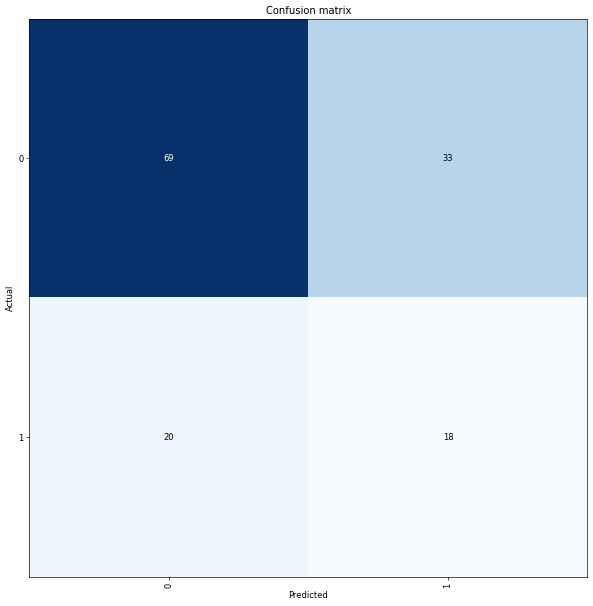

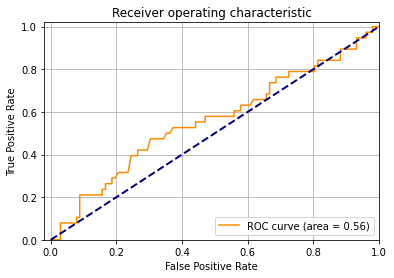

In [8]:
interp = ClassificationInterpretation.from_learner(learn, DatasetType.Test)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)
print("Accuracy: ", round(100 * get_acc(interp), 1), "%")
plot_roc_curve(interp)

cm = interp.confusion_matrix()
precision = cm[0][0] / (cm[0][0] + cm[0][1])
sensitifity = cm[1][1] / (cm[1][0] + cm[1][1])
print(f'precision: {precision}')
print(f'sensitifity: {sensitifity}')

In [11]:
?? GaussianNB

Accuracy: 0.7285714285714285
AUC: 0.627450980392157


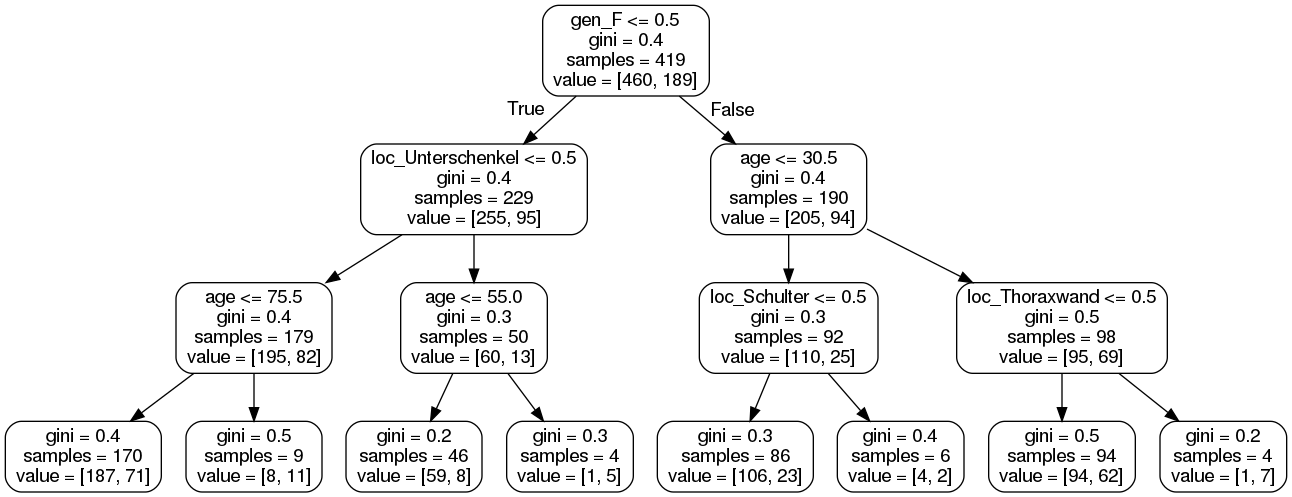

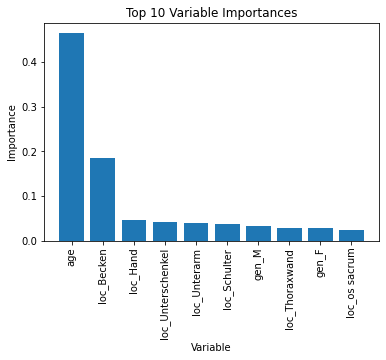

In [7]:
import pydotplus

features = pd.get_dummies(df_all)
label = np.array(features[DEP_KEY])
features= features.drop(DEP_KEY, axis = 1)
feature_list = list(features.columns)
features = np.array(features)

x = features[:trainlen]
y = label[:trainlen]

x_test = features[trainlen::]
y_test = label[trainlen::]

lim = 10
clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)

# Train Classifier
clf.fit(x, y)

# Get accuracy
y_pred = clf.predict(x_test)
p_pred = clf.predict_proba(x_test)[:, 1]
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("AUC:", metrics.roc_auc_score(y_test, p_pred))

# Analyse features (with lim)
importances = list(clf.feature_importances_)
x_values = list(range(len(importances)))
imp = importances
f_list = feature_list
sort_ind = np.flip(np.argsort(imp, ))
plt.bar(x_values[:lim], [imp[sort] for sort in sort_ind[:lim]], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values[:lim], [f_list[sort] for sort in sort_ind[:lim]], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title(f'Top {lim} Variable Importances');

# Make graph
tree = clf.estimators_[10] # Import tools needed for visualization
export_graphviz(tree, out_file = 'tree.dot', feature_names=feature_list, rounded=True, precision=1)
(graph, ) = pydot.graph_from_dot_file('tree.dot') # Write graph to a png file
Image(graph.create_png())

In [8]:
gnb = GaussianNB()

# Train Classifier
gnb.fit(x, y)

# Get accuracy
y_pred = gnb.predict(x_test)
p_pred = gnb.predict_proba(x_test)[:, 1]
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("AUC:", metrics.roc_auc_score(y_test, p_pred))

Accuracy: 0.6928571428571428
AUC: 0.5656604747162023


In [10]:
# RFC
auca = []
acca = []

features = pd.get_dummies(df_all)
label = np.array(features[DEP_KEY])
features= features.drop(DEP_KEY, axis = 1)
feature_list = list(features.columns)
features = np.array(features)

x = features[:trainlen]
y = label[:trainlen]

x_test = features[trainlen::]
y_test = label[trainlen::]

for i in range(20):
    lim = 10
    clf = GaussianNB()

    # Train Classifier
    clf.fit(x, y)

    # Get accuracy
    y_pred = clf.predict(x_test)
    p_pred = clf.predict_proba(x_test)[:, 1]
    loc_auc = metrics.roc_auc_score(y_test, p_pred)
    loc_acc = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred), 2))
    print("AUC:", round(metrics.roc_auc_score(y_test, p_pred), 2))
    
    acca.append(loc_acc)
    auca.append(loc_auc)

print(f'AUC: {round(np.mean(auca), 2)} +/- {round(np.std(auca), 2)}')
print(f'Accuracy: {round(np.mean(acca), 2)} +/- {round(np.std(acca), 2)}')

Accuracy: 0.69
AUC: 0.57
Accuracy: 0.69
AUC: 0.57
Accuracy: 0.69
AUC: 0.57
Accuracy: 0.69
AUC: 0.57
Accuracy: 0.69
AUC: 0.57
Accuracy: 0.69
AUC: 0.57
Accuracy: 0.69
AUC: 0.57
Accuracy: 0.69
AUC: 0.57
Accuracy: 0.69
AUC: 0.57
Accuracy: 0.69
AUC: 0.57
Accuracy: 0.69
AUC: 0.57
Accuracy: 0.69
AUC: 0.57
Accuracy: 0.69
AUC: 0.57
Accuracy: 0.69
AUC: 0.57
Accuracy: 0.69
AUC: 0.57
Accuracy: 0.69
AUC: 0.57
Accuracy: 0.69
AUC: 0.57
Accuracy: 0.69
AUC: 0.57
Accuracy: 0.69
AUC: 0.57
Accuracy: 0.69
AUC: 0.57
AUC: 0.57 +/- 0.0
Accuracy: 0.69 +/- 0.0


In [15]:
# RFC
auca = []
acca = []

features = pd.get_dummies(df_all)
label = np.array(features[DEP_KEY])
features= features.drop(DEP_KEY, axis = 1)
feature_list = list(features.columns)
features = np.array(features)

x = features[:trainlen]
y = label[:trainlen]

x_test = features[trainlen::]
y_test = label[trainlen::]

for i in range(20):
    lim = 10
    clf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=i)

    # Train Classifier
    clf.fit(x, y)

    # Get accuracy
    y_pred = clf.predict(x_test)
    p_pred = clf.predict_proba(x_test)[:, 1]
    loc_auc = metrics.roc_auc_score(y_test, p_pred)
    loc_acc = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred), 2))
    print("AUC:", round(metrics.roc_auc_score(y_test, p_pred), 2))
    
    acca.append(loc_acc)
    auca.append(loc_auc)

print(f'AUC: {round(np.mean(auca), 2)} +/- {round(np.std(auca), 2)}')
print(f'Accuracy: {round(np.mean(acca), 2)} +/- {round(np.std(acca), 2)}')

Accuracy: 0.73
AUC: 0.62
Accuracy: 0.73
AUC: 0.62
Accuracy: 0.73
AUC: 0.62
Accuracy: 0.73
AUC: 0.62
Accuracy: 0.73
AUC: 0.61
Accuracy: 0.73
AUC: 0.62
Accuracy: 0.73
AUC: 0.62
Accuracy: 0.73
AUC: 0.62
Accuracy: 0.73
AUC: 0.61
Accuracy: 0.73
AUC: 0.62
Accuracy: 0.73
AUC: 0.63
Accuracy: 0.73
AUC: 0.61
Accuracy: 0.73
AUC: 0.62
Accuracy: 0.74
AUC: 0.61
Accuracy: 0.73
AUC: 0.61
Accuracy: 0.73
AUC: 0.61
Accuracy: 0.73
AUC: 0.61
Accuracy: 0.72
AUC: 0.62
Accuracy: 0.73
AUC: 0.62
Accuracy: 0.73
AUC: 0.62
AUC: 0.62 +/- 0.01
Accuracy: 0.73 +/- 0.0


In [16]:
auca = []
acca = []

for i in range(10):
    # train
    learn = tabular_learner(data, layers=[200,100,100], metrics=accuracy)
    learn.fit_one_cycle(8, max_lr=1e-3)
    interp = ClassificationInterpretation.from_learner(learn, DatasetType.Test)
    
    # get acc
    acca.append(get_acc(interp))
    
    # get auc
    x, y = roc_curve(interp.preds[:, 1], interp.y_true)
    auc_v = auc(x, y)
    auca.append(auc_v)

print(f'AUC: {round(np.mean(auca), 3)} +/- {round(np.std(auca), 3)}')
print(f'Accuracy: {round(np.mean(acca), 3)} +/- {round(np.std(acca), 3)}')

epoch,train_loss,valid_loss,accuracy,time
0,0.734315,0.642681,0.728571,00:01
1,0.675409,0.668341,0.728571,00:01
2,0.627066,0.670438,0.635714,00:01
3,0.586723,0.644781,0.664286,00:01
4,0.542046,0.712993,0.628571,00:01
5,0.497169,0.729496,0.642857,00:01
6,0.460274,0.740469,0.621429,00:01
7,0.431799,0.730239,0.628571,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.701225,0.672601,0.728571,00:01
1,0.650171,0.650028,0.728571,00:01
2,0.613102,0.631233,0.728571,00:01
3,0.574219,0.635950,0.650000,00:01
4,0.531659,0.700916,0.621429,00:01
5,0.488073,0.754259,0.621429,00:01
6,0.449652,0.778710,0.621429,00:01
7,0.421711,0.766632,0.614286,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.745160,0.639509,0.728571,00:01
1,0.702812,0.636625,0.728571,00:01
2,0.645276,0.610402,0.721429,00:01
3,0.597367,0.625955,0.657143,00:01
4,0.547516,0.711612,0.621429,00:01
5,0.498474,0.788110,0.571429,00:01
6,0.453162,0.787433,0.600000,00:01
7,0.418546,0.792680,0.607143,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.770097,0.800609,0.271429,00:01
1,0.694550,0.788485,0.271429,00:01
2,0.638838,0.776949,0.292857,00:01
3,0.590714,0.692707,0.557143,00:01
4,0.544226,0.655903,0.635714,00:01
5,0.500562,0.680544,0.650000,00:01
6,0.457273,0.693850,0.642857,00:01
7,0.427185,0.693704,0.642857,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.715903,0.626566,0.728571,00:01
1,0.663357,0.626054,0.728571,00:01
2,0.620762,0.634653,0.721429,00:01
3,0.581907,0.644488,0.650000,00:01
4,0.538779,0.688388,0.642857,00:01
5,0.492150,0.729512,0.614286,00:01
6,0.453650,0.769029,0.592857,00:01
7,0.422834,0.780577,0.585714,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.743176,0.707472,0.271429,00:01
1,0.682612,0.655690,0.728571,00:01
2,0.647426,0.629642,0.707143,00:01
3,0.610085,0.605850,0.685714,00:01
4,0.569095,0.640514,0.657143,00:01
5,0.526702,0.702197,0.650000,00:01
6,0.485663,0.718144,0.628571,00:01
7,0.454178,0.716746,0.628571,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.755260,0.605072,0.728571,00:01
1,0.681504,0.608607,0.728571,00:01
2,0.638667,0.606201,0.728571,00:01
3,0.600738,0.611027,0.692857,00:01
4,0.559611,0.628428,0.650000,00:01
5,0.513673,0.675111,0.657143,00:01
6,0.474684,0.701030,0.621429,00:01
7,0.444698,0.707028,0.614286,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.757888,0.795308,0.271429,00:01
1,0.705932,0.747550,0.271429,00:01
2,0.666718,0.669816,0.578571,00:01
3,0.618988,0.668968,0.550000,00:01
4,0.573941,0.730478,0.500000,00:01
5,0.534223,0.727101,0.571429,00:01
6,0.490697,0.726743,0.571429,00:01
7,0.458641,0.728286,0.564286,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.764379,0.880573,0.271429,00:01
1,0.700861,0.820853,0.271429,00:01
2,0.653895,0.722414,0.400000,00:01
3,0.607875,0.695396,0.550000,00:01
4,0.566506,0.714250,0.585714,00:01
5,0.516213,0.738579,0.621429,00:01
6,0.472964,0.739102,0.657143,00:01
7,0.439198,0.755626,0.621429,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.738649,0.687945,0.728571,00:01
1,0.681102,0.674163,0.721429,00:01
2,0.629720,0.664229,0.657143,00:01
3,0.588165,0.623574,0.642857,00:01
4,0.545507,0.653212,0.600000,00:01
5,0.504814,0.729079,0.614286,00:01
6,0.462312,0.720084,0.607143,00:01
7,0.430256,0.722583,0.614286,00:01


AUC: 0.574 +/- 0.024
Accuracy: 0.616 +/- 0.02


In [17]:
auca = []
acca = []

for i in range(10):
    # train
    learn = tabular_learner(data, layers=[200,100], metrics=accuracy)
    learn.fit_one_cycle(8, max_lr=1e-3)
    interp = ClassificationInterpretation.from_learner(learn, DatasetType.Test)
    
    # get acc
    acca.append(get_acc(interp))
    
    # get auc
    x, y = roc_curve(interp.preds[:, 1], interp.y_true)
    auc_v = auc(x, y)
    auca.append(auc_v)

print(f'AUC: {round(np.mean(auca), 3)} +/- {round(np.std(auca), 3)}')
print(f'Accuracy: {round(np.mean(acca), 3)} +/- {round(np.std(acca), 3)}')

epoch,train_loss,valid_loss,accuracy,time
0,0.740584,0.613572,0.728571,00:01
1,0.674456,0.585472,0.728571,00:01
2,0.630256,0.577302,0.728571,00:01
3,0.589570,0.582808,0.728571,00:01
4,0.546213,0.639002,0.664286,00:01
5,0.504580,0.701009,0.600000,00:01
6,0.469966,0.714590,0.607143,00:01
7,0.446973,0.717605,0.614286,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.746208,0.666192,0.728571,00:01
1,0.696917,0.628796,0.728571,00:01
2,0.651816,0.605503,0.728571,00:01
3,0.604108,0.604667,0.685714,00:01
4,0.558333,0.644592,0.650000,00:01
5,0.514849,0.694763,0.607143,00:01
6,0.483989,0.688399,0.585714,00:01
7,0.456231,0.692630,0.592857,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.767530,0.770213,0.271429,00:01
1,0.708652,0.808867,0.271429,00:01
2,0.665475,0.746936,0.292857,00:01
3,0.620528,0.699071,0.500000,00:01
4,0.575152,0.694521,0.542857,00:01
5,0.527833,0.673437,0.614286,00:01
6,0.486785,0.674116,0.621429,00:01
7,0.460720,0.678746,0.621429,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.712039,0.663544,0.728571,00:01
1,0.671612,0.633347,0.728571,00:01
2,0.630447,0.606730,0.728571,00:01
3,0.591050,0.613653,0.685714,00:01
4,0.549983,0.724381,0.550000,00:01
5,0.511873,0.738152,0.607143,00:01
6,0.478899,0.754335,0.592857,00:01
7,0.451484,0.758679,0.578571,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.767736,0.713249,0.271429,00:01
1,0.711804,0.688949,0.600000,00:01
2,0.670815,0.664720,0.635714,00:01
3,0.624229,0.653861,0.642857,00:01
4,0.574756,0.702990,0.557143,00:01
5,0.536699,0.759826,0.564286,00:01
6,0.495828,0.757505,0.550000,00:01
7,0.466732,0.759585,0.550000,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.766618,0.712280,0.271429,00:01
1,0.718926,0.714199,0.271429,00:01
2,0.676363,0.698828,0.507143,00:01
3,0.625573,0.663281,0.585714,00:01
4,0.583406,0.687244,0.614286,00:01
5,0.538631,0.687671,0.628571,00:01
6,0.503352,0.693776,0.628571,00:01
7,0.477171,0.699937,0.621429,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.777325,0.700366,0.271429,00:01
1,0.718081,0.662487,0.728571,00:01
2,0.672101,0.633560,0.728571,00:01
3,0.625793,0.624176,0.685714,00:01
4,0.576762,0.689878,0.621429,00:01
5,0.535104,0.719461,0.614286,00:01
6,0.501409,0.730219,0.607143,00:01
7,0.473404,0.724861,0.614286,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.740152,0.712997,0.271429,00:01
1,0.684608,0.724905,0.271429,00:01
2,0.637999,0.707162,0.428571,00:01
3,0.594854,0.656834,0.621429,00:01
4,0.550068,0.706497,0.585714,00:01
5,0.515190,0.711788,0.600000,00:01
6,0.476219,0.715938,0.628571,00:01
7,0.448356,0.715135,0.628571,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.753611,0.630686,0.728571,00:01
1,0.686113,0.600119,0.728571,00:01
2,0.641010,0.593925,0.728571,00:01
3,0.599419,0.614146,0.692857,00:01
4,0.553557,0.690852,0.628571,00:01
5,0.514764,0.784390,0.592857,00:01
6,0.481153,0.764188,0.600000,00:01
7,0.456525,0.773908,0.592857,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.798928,0.694970,0.278571,00:01
1,0.726012,0.651735,0.728571,00:01
2,0.673229,0.621774,0.721429,00:01
3,0.621854,0.602781,0.707143,00:01
4,0.576671,0.626630,0.671429,00:01
5,0.533192,0.675225,0.650000,00:01
6,0.491696,0.689181,0.628571,00:01
7,0.466712,0.688589,0.635714,00:01


AUC: 0.568 +/- 0.017
Accuracy: 0.61 +/- 0.023


## Now only Radiomics features

In [12]:
df, _ = get_df_paths()
dis = get_advanced_dis_df(df)

PATH = 'radiomics'
REM_KEYS = ['Unnamed: 0', 'label2']
DEP_KEY = 'label1'

df, _ = get_df_paths()
dis = get_advanced_dis_df(df)

PATH = 'radiomics'
REM_KEYS = ['Unnamed: 0', 'label2']
DEP_KEY = 'label1'

train = pd.read_csv(f'{PATH}/train.csv')
valid = pd.read_csv(f'{PATH}/valid.csv')
test = pd.read_csv(f'{PATH}/test.csv')

train = train.fillna(0).drop(columns=REM_KEYS)
valid = valid.fillna(0).drop(columns=REM_KEYS)
test = test.fillna(0).drop(columns=REM_KEYS)

dis = get_exp_keys('train', dis)
dis = get_exp_keys('valid', dis)
dis = get_exp_keys('test', dis)

train = train.fillna(0)
valid = valid.fillna(0)
test = test.fillna(0)

REM_KEYS = list(train.keys())
REM_KEYS.remove('label1')

dis = get_exp_keys('train', dis)
dis = get_exp_keys('valid', dis)
dis = get_exp_keys('test', dis)

train = train.fillna(0)
valid = valid.fillna(0)
test = test.fillna(0)


ages = get_df_dis(df, out=False)
locs = df['Befundlokalisation']
gend = [name[0] for name in df[F_KEY]]

trainlen = len(train)
print(trainlen)
validlen = len(valid)
print(validlen)

# resulting valid indexes
valid_idx = range(trainlen, trainlen + validlen)

# build df
df_all = train.append(valid)

# display df
df_all.head()

df_test = test

649
140


In [13]:
# Data Preparation
procs = [FillMissing, Categorify, Normalize]

# continous names
cont_names = list(train.keys())
contl = len(cont_names)
cont_names = cont_names[1:(contl)-5]
cont_names = cont_names[:161]
train, valid, test = apply_cat(train, valid, test, dis, 'ent', ent)

# categrorical names
cat_names = ['loc', 'gen', 'age']

# create databunch
data = TabularDataBunch.from_df(
    path=PATH, df=df_all, dep_var=DEP_KEY, valid_idx=valid_idx,
    cat_names=[], cont_names=cont_names, test_df=test, procs=procs)

data_test = TabularDataBunch.from_df(
    path=PATH, df=df_test, dep_var=DEP_KEY, valid_idx=[],
    cat_names=[], cont_names=cont_names, procs=procs)

data.test_ds.x = data_test.train_ds.x
data.test_ds.y = data_test.train_ds.y

# Show databunch
data.train_dl.num_workers = 0
data.train_dl.batch_size = 32
data.show_batch(rows=10)


/home/biomech/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,wavelet-LLH_firstorder_10Percentile,wavelet-LLH_firstorder_90Percentile,wavelet-LLH_firstorder_Energy,wavelet-LLH_firstorder_Entropy,wavelet-LLH_firstorder_InterquartileRange,wavelet-LLH_firstorder_Kurtosis,wavelet-LLH_firstorder_Maximum,wavelet-LLH_firstorder_MeanAbsoluteDeviation,wavelet-LLH_firstorder_Mean,wavelet-LLH_firstorder_Median,wavelet-LLH_firstorder_Minimum,wavelet-LLH_firstorder_Range,wavelet-LLH_firstorder_RobustMeanAbsoluteDeviation,wavelet-LLH_firstorder_RootMeanSquared,wavelet-LLH_firstorder_Skewness,wavelet-LLH_firstorder_TotalEnergy,wavelet-LLH_firstorder_Uniformity,wavelet-LLH_firstorder_Variance,wavelet-LHL_firstorder_10Percentile,wavelet-LHL_firstorder_90Percentile,wavelet-LHL_firstorder_Energy,wavelet-LHL_firstorder_Entropy,wavelet-LHL_firstorder_InterquartileRange,wavelet-LHL_firstorder_Kurtosis,wavelet-LHL_firstorder_Maximum,wavelet-LHL_firstorder_MeanAbsoluteDeviation,wavelet-LHL_firstorder_Mean,wavelet-LHL_firstorder_Median,wavelet-LHL_firstorder_Minimum,wavelet-LHL_firstorder_Range,wavelet-LHL_firstorder_RobustMeanAbsoluteDeviation,wavelet-LHL_firstorder_RootMeanSquared,wavelet-LHL_firstorder_Skewness,wavelet-LHL_firstorder_TotalEnergy,wavelet-LHL_firstorder_Uniformity,wavelet-LHL_firstorder_Variance,wavelet-LHH_firstorder_10Percentile,wavelet-LHH_firstorder_90Percentile,wavelet-LHH_firstorder_Energy,wavelet-LHH_firstorder_Entropy,wavelet-LHH_firstorder_InterquartileRange,wavelet-LHH_firstorder_Kurtosis,wavelet-LHH_firstorder_Maximum,wavelet-LHH_firstorder_MeanAbsoluteDeviation,wavelet-LHH_firstorder_Mean,wavelet-LHH_firstorder_Median,wavelet-LHH_firstorder_Minimum,wavelet-LHH_firstorder_Range,wavelet-LHH_firstorder_RobustMeanAbsoluteDeviation,wavelet-LHH_firstorder_RootMeanSquared,wavelet-LHH_firstorder_Skewness,wavelet-LHH_firstorder_TotalEnergy,wavelet-LHH_firstorder_Uniformity,wavelet-LHH_firstorder_Variance,wavelet-HLL_firstorder_10Percentile,wavelet-HLL_firstorder_90Percentile,wavelet-HLL_firstorder_Energy,wavelet-HLL_firstorder_Entropy,wavelet-HLL_firstorder_InterquartileRange,wavelet-HLL_firstorder_Kurtosis,wavelet-HLL_firstorder_Maximum,wavelet-HLL_firstorder_MeanAbsoluteDeviation,wavelet-HLL_firstorder_Mean,wavelet-HLL_firstorder_Median,wavelet-HLL_firstorder_Minimum,wavelet-HLL_firstorder_Range,wavelet-HLL_firstorder_RobustMeanAbsoluteDeviation,wavelet-HLL_firstorder_RootMeanSquared,wavelet-HLL_firstorder_Skewness,wavelet-HLL_firstorder_TotalEnergy,wavelet-HLL_firstorder_Uniformity,wavelet-HLL_firstorder_Variance,wavelet-HLH_firstorder_10Percentile,wavelet-HLH_firstorder_90Percentile,wavelet-HLH_firstorder_Energy,wavelet-HLH_firstorder_Entropy,wavelet-HLH_firstorder_InterquartileRange,wavelet-HLH_firstorder_Kurtosis,wavelet-HLH_firstorder_Maximum,wavelet-HLH_firstorder_MeanAbsoluteDeviation,wavelet-HLH_firstorder_Mean,wavelet-HLH_firstorder_Median,wavelet-HLH_firstorder_Minimum,wavelet-HLH_firstorder_Range,wavelet-HLH_firstorder_RobustMeanAbsoluteDeviation,wavelet-HLH_firstorder_RootMeanSquared,wavelet-HLH_firstorder_Skewness,wavelet-HLH_firstorder_TotalEnergy,wavelet-HLH_firstorder_Uniformity,wavelet-HLH_firstorder_Variance,wavelet-HHL_firstorder_10Percentile,wavelet-HHL_firstorder_90Percentile,wavelet-HHL_firstorder_Energy,wavelet-HHL_firstorder_Entropy,wavelet-HHL_firstorder_InterquartileRange,wavelet-HHL_firstorder_Kurtosis,wavelet-HHL_firstorder_Maximum,wavelet-HHL_firstorder_MeanAbsoluteDeviation,wavelet-HHL_firstorder_Mean,wavelet-HHL_firstorder_Median,wa

In [14]:
df_all.head()

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,...,log-sigma-3-0-mm-3D_firstorder_Mean,log-sigma-3-0-mm-3D_firstorder_Median,log-sigma-3-0-mm-3D_firstorder_Minimum,log-sigma-3-0-mm-3D_firstorder_Range,log-sigma-3-0-mm-3D_firstorder_RobustMeanAbsoluteDeviation,log-sigma-3-0-mm-3D_firstorder_RootMeanSquared,log-sigma-3-0-mm-3D_firstorder_Skewness,log-sigma-3-0-mm-3D_firstorder_TotalEnergy,log-sigma-3-0-mm-3D_firstorder_Uniformity,log-sigma-3-0-mm-3D_firstorder_Variance
0,15.500020,58.765416,1.308054e+10,4.032506,21.951561,8.831832,174.001975,17.160024,38.396903,34.507913,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,47.467195,66.612836,4.626589e+08,2.697371,10.327073,5.225828,77.232934,6.350329,56.910082,57.581181,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-24.941871,42.195378,1.114753e+10,4.553707,35.356870,7.945965,116.520749,25.008526,4.948465,6.494844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.175243,58.478122,3.331790e+09,3.858980,17.818996,5.631246,88.865517,15.561807,22.142780,18.896396,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6.115728,66.987773,6.860790e+09,4.145085,28.682225,18.094700,261.096939,20.500603,33.386308,27.626637,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


epoch,train_loss,valid_loss,accuracy,time
0,0.733894,0.678896,0.578571,00:01
1,0.678202,0.652837,0.621429,00:01
2,0.624740,0.621176,0.735714,00:01
3,0.564970,0.627376,0.671429,00:01
4,0.509436,0.622778,0.700000,00:01
5,0.457448,0.606633,0.700000,00:01
6,0.410721,0.615953,0.671429,00:01
7,0.369310,0.621838,0.671429,00:00


Accuracy:  74.3 %
precision: 0.8431372549019608
sensitifity: 0.47368421052631576


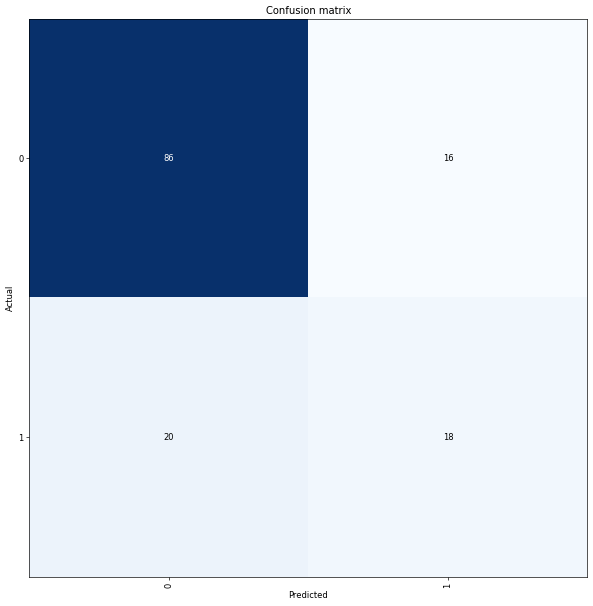

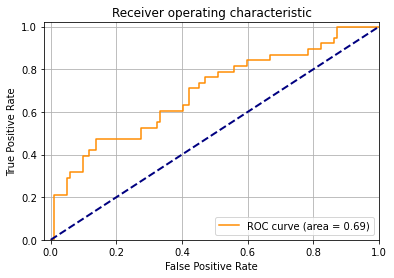

In [21]:
learn = tabular_learner(data, layers=[200,100,100], metrics=accuracy)
learn.fit_one_cycle(8, max_lr=1e-3)
interp = ClassificationInterpretation.from_learner(learn, DatasetType.Test)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)
print("Accuracy: ", round(100 * get_acc(interp), 1), "%")
plot_roc_curve(interp)

cm = interp.confusion_matrix()
precision = cm[0][0] / (cm[0][0] + cm[0][1])
sensitifity = cm[1][1] / (cm[1][0] + cm[1][1])
print(f'precision: {precision}')
print(f'sensitifity: {sensitifity}')

In [22]:
auca = []
acca = []

for i in range(10):
    # train
    learn = tabular_learner(data, layers=[200,100], metrics=accuracy)
    learn.fit_one_cycle(8, max_lr=1e-3)
    interp = ClassificationInterpretation.from_learner(learn, DatasetType.Test)
    
    # get acc
    acca.append(get_acc(interp))
    
    # get auc
    x, y = roc_curve(interp.preds[:, 1], interp.y_true)
    auc_v = auc(x, y)
    auca.append(auc_v)

print(f'AUC: {round(np.mean(auca), 3)} +/- {round(np.std(auca), 3)}')
print(f'Accuracy: {round(np.mean(acca), 3)} +/- {round(np.std(acca), 3)}')

epoch,train_loss,valid_loss,accuracy,time
0,0.715590,0.647424,0.578571,00:01
1,0.655753,0.638451,0.642857,00:01
2,0.601708,0.637273,0.657143,00:01
3,0.556009,0.643456,0.721429,00:01
4,0.509270,0.621266,0.692857,00:01
5,0.465591,0.629076,0.678571,00:01
6,0.424261,0.626429,0.685714,00:01
7,0.390355,0.615339,0.678571,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.746643,0.701166,0.535714,00:01
1,0.681963,0.676759,0.628571,00:01
2,0.630233,0.695763,0.635714,00:01
3,0.564042,0.741079,0.664286,00:01
4,0.518729,0.647093,0.692857,00:01
5,0.468501,0.670263,0.700000,00:01
6,0.430033,0.688423,0.714286,00:00
7,0.396827,0.681719,0.700000,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.768327,0.677721,0.557143,00:01
1,0.693762,0.696832,0.621429,00:01
2,0.624451,0.689994,0.721429,00:01
3,0.565733,0.630506,0.685714,00:01
4,0.514520,0.693867,0.714286,00:01
5,0.460773,0.633726,0.757143,00:01
6,0.414255,0.628279,0.764286,00:01
7,0.380803,0.640740,0.757143,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.757255,0.720781,0.521429,00:01
1,0.685665,0.695395,0.607143,00:01
2,0.625008,0.704156,0.585714,00:01
3,0.576945,0.677535,0.714286,00:01
4,0.530870,0.657152,0.678571,00:01
5,0.485110,0.649894,0.707143,00:01
6,0.439960,0.679768,0.700000,00:01
7,0.411691,0.670223,0.707143,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.779803,0.769880,0.442857,00:01
1,0.699225,0.697653,0.614286,00:01
2,0.646260,0.700989,0.671429,00:01
3,0.590343,0.667073,0.642857,00:01
4,0.527395,0.674665,0.678571,00:01
5,0.483405,0.631942,0.721429,00:01
6,0.443018,0.642882,0.714286,00:01
7,0.410848,0.649634,0.685714,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.725448,0.724686,0.464286,00:01
1,0.681900,0.707576,0.542857,00:01
2,0.635590,0.670393,0.664286,00:01
3,0.592192,0.609376,0.742857,00:00
4,0.540913,0.607902,0.692857,00:01
5,0.495744,0.606704,0.671429,00:00
6,0.454821,0.616204,0.678571,00:01
7,0.420565,0.611100,0.692857,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.733874,0.667848,0.621429,00:01
1,0.666826,0.745567,0.600000,00:01
2,0.627709,0.786980,0.600000,00:01
3,0.580618,0.683763,0.657143,00:01
4,0.521589,0.681136,0.657143,00:00
5,0.476775,0.620181,0.721429,00:01
6,0.434506,0.620075,0.750000,00:00
7,0.405680,0.623919,0.735714,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.754556,0.713991,0.500000,00:01
1,0.697432,0.664726,0.614286,00:01
2,0.648275,0.652354,0.671429,00:01
3,0.595300,0.599380,0.735714,00:00
4,0.545875,0.607131,0.742857,00:01
5,0.498699,0.588474,0.742857,00:00
6,0.452377,0.594145,0.750000,00:01
7,0.422392,0.618424,0.721429,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.675460,0.613493,0.700000,00:00
1,0.624150,0.584454,0.742857,00:01
2,0.576830,0.697109,0.678571,00:01
3,0.536038,0.600124,0.714286,00:01
4,0.494030,0.595226,0.714286,00:00
5,0.451786,0.597695,0.714286,00:01
6,0.419349,0.576872,0.728571,00:00
7,0.391704,0.573177,0.728571,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.711029,0.704130,0.557143,00:01
1,0.657049,0.702002,0.600000,00:01
2,0.610493,0.621629,0.664286,00:01
3,0.568799,0.629886,0.750000,00:00
4,0.525917,0.651033,0.700000,00:01
5,0.486571,0.589341,0.757143,00:01
6,0.440530,0.571554,0.735714,00:01
7,0.413295,0.575930,0.735714,00:01


AUC: 0.736 +/- 0.022
Accuracy: 0.738 +/- 0.026


In [23]:
auca = []
acca = []

for i in range(10):
    # train
    learn = tabular_learner(data, layers=[200,100,100], metrics=accuracy)
    learn.fit_one_cycle(8, max_lr=1e-3)
    interp = ClassificationInterpretation.from_learner(learn, DatasetType.Test)
    
    # get acc
    acca.append(get_acc(interp))
    
    # get auc
    x, y = roc_curve(interp.preds[:, 1], interp.y_true)
    auc_v = auc(x, y)
    auca.append(auc_v)

print(f'AUC: {round(np.mean(auca), 3)} +/- {round(np.std(auca), 3)}')
print(f'Accuracy: {round(np.mean(acca), 3)} +/- {round(np.std(acca), 3)}')

epoch,train_loss,valid_loss,accuracy,time
0,0.739231,0.734185,0.450000,00:01
1,0.681404,0.637355,0.664286,00:01
2,0.637697,0.668136,0.614286,00:01
3,0.591335,0.669991,0.628571,00:01
4,0.535938,0.592462,0.750000,00:01
5,0.482054,0.597341,0.671429,00:01
6,0.437443,0.612002,0.685714,00:01
7,0.401121,0.611926,0.721429,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.747916,0.656173,0.657143,00:01
1,0.690558,0.718647,0.685714,00:01
2,0.630905,0.663129,0.664286,00:01
3,0.567915,0.735383,0.685714,00:01
4,0.502855,0.751899,0.685714,00:01
5,0.456101,0.724177,0.692857,00:01
6,0.409690,0.710525,0.692857,00:01
7,0.377739,0.708649,0.707143,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.751872,0.742899,0.407143,00:01
1,0.693593,0.703023,0.592857,00:01
2,0.647311,0.686048,0.635714,00:01
3,0.603368,0.691844,0.628571,00:01
4,0.548502,0.668831,0.635714,00:01
5,0.492416,0.675140,0.671429,00:01
6,0.448589,0.701049,0.664286,00:01
7,0.418905,0.705904,0.650000,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.778572,0.707583,0.585714,00:01
1,0.702152,0.793974,0.600000,00:01
2,0.639474,0.775006,0.678571,00:01
3,0.597545,0.695738,0.671429,00:01
4,0.549116,0.784891,0.607143,00:01
5,0.491997,0.722774,0.685714,00:01
6,0.440891,0.747275,0.685714,00:01
7,0.398649,0.752042,0.671429,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.715920,0.673727,0.557143,00:01
1,0.665494,0.636266,0.642857,00:01
2,0.607633,0.635603,0.657143,00:01
3,0.566202,0.578807,0.742857,00:01
4,0.521905,0.657825,0.707143,00:01
5,0.470721,0.570426,0.742857,00:01
6,0.422674,0.608132,0.742857,00:00
7,0.392418,0.599520,0.757143,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.749026,0.771419,0.400000,00:01
1,0.678876,0.693470,0.528571,00:01
2,0.621358,0.658938,0.650000,00:01
3,0.571449,0.668863,0.664286,00:01
4,0.517855,0.630230,0.657143,00:01
5,0.471312,0.654723,0.678571,00:00
6,0.425999,0.617396,0.692857,00:01
7,0.390587,0.611690,0.678571,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.756075,0.710301,0.521429,00:01
1,0.680051,0.735935,0.614286,00:01
2,0.625075,0.750058,0.592857,00:01
3,0.575089,0.703036,0.692857,00:01
4,0.527908,0.627136,0.714286,00:01
5,0.478620,0.722984,0.692857,00:01
6,0.437033,0.678898,0.707143,00:01
7,0.402459,0.661701,0.714286,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.723638,0.606131,0.750000,00:01
1,0.655877,0.654912,0.621429,00:01
2,0.597408,0.661000,0.692857,00:01
3,0.541911,0.605209,0.700000,00:01
4,0.489344,0.646868,0.685714,00:01
5,0.448950,0.683376,0.685714,00:01
6,0.403343,0.656339,0.714286,00:01
7,0.362439,0.678797,0.714286,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.751862,0.738498,0.450000,00:01
1,0.679342,0.641005,0.642857,00:01
2,0.625554,0.668649,0.692857,00:01
3,0.573838,0.649825,0.671429,00:01
4,0.520006,0.585814,0.685714,00:01
5,0.462523,0.580649,0.707143,00:01
6,0.420415,0.555068,0.721429,00:01
7,0.385561,0.571948,0.714286,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.710496,0.694064,0.492857,00:01
1,0.643262,0.670382,0.650000,00:00
2,0.598999,0.652693,0.714286,00:01
3,0.558209,0.723601,0.664286,00:01
4,0.510898,0.631769,0.700000,00:01
5,0.459111,0.649334,0.678571,00:01
6,0.418255,0.662135,0.671429,00:01
7,0.383907,0.653679,0.685714,00:01


AUC: 0.721 +/- 0.025
Accuracy: 0.727 +/- 0.021


In [17]:
auca = []
acca = []

features = pd.get_dummies(df_all)
label = np.array(features[DEP_KEY])
features= features.drop(DEP_KEY, axis = 1)
feature_list = list(features.columns)
features = np.array(features)

x = features[:trainlen]
y = label[:trainlen]

x_test = features[trainlen::]
y_test = label[trainlen::]

for i in range(20):
    lim = 10
    clf = GaussianNB()

    # Train Classifier
    clf.fit(x, y)

    # Get accuracy
    y_pred = clf.predict(x_test)
    p_pred = clf.predict_proba(x_test)[:, 1]
    loc_auc = metrics.roc_auc_score(y_test, p_pred)
    loc_acc = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred), 2))
    print("AUC:", round(metrics.roc_auc_score(y_test, p_pred), 2))
    
    acca.append(loc_acc)
    auca.append(loc_auc)

print(f'AUC: {round(np.mean(auca), 2)} +/- {round(np.std(auca), 2)}')
print(f'Accuracy: {round(np.mean(acca), 2)} +/- {round(np.std(acca), 2)}')

Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
AUC: 0.68 +/- 0.0
Accuracy: 0.76 +/- 0.0


In [25]:
auca = []
acca = []

features = pd.get_dummies(df_all)
label = np.array(features[DEP_KEY])
features= features.drop(DEP_KEY, axis = 1)
feature_list = list(features.columns)
features = np.array(features)

x = features[:trainlen]
y = label[:trainlen]

x_test = features[trainlen::]
y_test = label[trainlen::]

for i in range(20):
    lim = 10
    clf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=i)

    # Train Classifier
    clf.fit(x, y)

    # Get accuracy
    y_pred = clf.predict(x_test)
    p_pred = clf.predict_proba(x_test)[:, 1]
    loc_auc = metrics.roc_auc_score(y_test, p_pred)
    loc_acc = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred), 2))
    print("AUC:", round(metrics.roc_auc_score(y_test, p_pred), 2))
    
    acca.append(loc_acc)
    auca.append(loc_auc)

print(f'AUC: {round(np.mean(auca), 2)} +/- {round(np.std(auca), 2)}')
print(f'Accuracy: {round(np.mean(acca), 2)} +/- {round(np.std(acca), 2)}')

Accuracy: 0.74
AUC: 0.74
Accuracy: 0.74
AUC: 0.72
Accuracy: 0.75
AUC: 0.74
Accuracy: 0.74
AUC: 0.72
Accuracy: 0.75
AUC: 0.72
Accuracy: 0.73
AUC: 0.72
Accuracy: 0.76
AUC: 0.73
Accuracy: 0.75
AUC: 0.74
Accuracy: 0.75
AUC: 0.74
Accuracy: 0.77
AUC: 0.73
Accuracy: 0.74
AUC: 0.72
Accuracy: 0.74
AUC: 0.73
Accuracy: 0.73
AUC: 0.72
Accuracy: 0.76
AUC: 0.74
Accuracy: 0.74
AUC: 0.74
Accuracy: 0.74
AUC: 0.72
Accuracy: 0.74
AUC: 0.74
Accuracy: 0.74
AUC: 0.73
Accuracy: 0.74
AUC: 0.72
Accuracy: 0.75
AUC: 0.73
AUC: 0.73 +/- 0.01
Accuracy: 0.75 +/- 0.01


## Get datasets with all features

In [20]:
df, _ = get_df_paths()
dis = get_advanced_dis_df(df)

PATH = 'radiomics'
REM_KEYS = ['Unnamed: 0', 'label1', 'label2']
DEP_KEY = 'label1'

REM_KEYS.remove(DEP_KEY)
print(REM_KEYS)

train = pd.read_csv(f'{PATH}/train.csv')
valid = pd.read_csv(f'{PATH}/valid.csv')
test = pd.read_csv(f'{PATH}/test.csv')

dis = get_exp_keys('train', dis)
dis = get_exp_keys('valid', dis)
dis = get_exp_keys('test', dis)

train = train.fillna(0)
valid = valid.fillna(0)
test = test.fillna(0)


ages = get_df_dis(df, out=False)
locs = df['Befundlokalisation']
gend = [name[0] for name in df[F_KEY]]

train, valid, test = apply_cat(train, valid, test, dis, 'age', ages)
train, valid, test = apply_cat(train, valid, test, dis, 'loc', locs)
train, valid, test = apply_cat(train, valid, test, dis, 'gen', gend)

trainlen = len(train)
print(trainlen)
validlen = len(valid)
print(validlen)

# resulting valid indexes
valid_idx = range(trainlen, trainlen + validlen)

# build df
df_all = train.append(valid)
df_all = df_all.drop(columns=REM_KEYS)
train = train.drop(columns=REM_KEYS)

# display df
df_all.head()

df_test = test.drop(columns=REM_KEYS)

# Data Preparation
procs = [FillMissing, Categorify, Normalize]

# continous names
cont_names = list(train.keys())
contl = len(cont_names)
cont_names = cont_names[1:(contl)-5]
cont_names = cont_names[:161]


# categrorical names
cat_names = ['loc', 'gen', 'age']

# create databunch
data = TabularDataBunch.from_df(
    path=PATH, df=df_all, dep_var=DEP_KEY, valid_idx=valid_idx,
    cat_names= cat_names, cont_names = cont_names, test_df=test, procs=procs)

data_test = TabularDataBunch.from_df(
    path=PATH, df=df_test, dep_var=DEP_KEY, valid_idx=[],
    cat_names= cat_names, cont_names = cont_names, procs=procs)

data.test_ds.x = data_test.train_ds.x
data.test_ds.y = data_test.train_ds.y

# Show databunch
data.train_dl.num_workers = 0
data.train_dl.batch_size = 32
data.show_batch(rows=10)

df_all[DEP_KEY]

['Unnamed: 0', 'label2']
649
140


/home/biomech/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


loc,gen,age,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,wavelet-LLH_firstorder_10Percentile,wavelet-LLH_firstorder_90Percentile,wavelet-LLH_firstorder_Energy,wavelet-LLH_firstorder_Entropy,wavelet-LLH_firstorder_InterquartileRange,wavelet-LLH_firstorder_Kurtosis,wavelet-LLH_firstorder_Maximum,wavelet-LLH_firstorder_MeanAbsoluteDeviation,wavelet-LLH_firstorder_Mean,wavelet-LLH_firstorder_Median,wavelet-LLH_firstorder_Minimum,wavelet-LLH_firstorder_Range,wavelet-LLH_firstorder_RobustMeanAbsoluteDeviation,wavelet-LLH_firstorder_RootMeanSquared,wavelet-LLH_firstorder_Skewness,wavelet-LLH_firstorder_TotalEnergy,wavelet-LLH_firstorder_Uniformity,wavelet-LLH_firstorder_Variance,wavelet-LHL_firstorder_10Percentile,wavelet-LHL_firstorder_90Percentile,wavelet-LHL_firstorder_Energy,wavelet-LHL_firstorder_Entropy,wavelet-LHL_firstorder_InterquartileRange,wavelet-LHL_firstorder_Kurtosis,wavelet-LHL_firstorder_Maximum,wavelet-LHL_firstorder_MeanAbsoluteDeviation,wavelet-LHL_firstorder_Mean,wavelet-LHL_firstorder_Median,wavelet-LHL_firstorder_Minimum,wavelet-LHL_firstorder_Range,wavelet-LHL_firstorder_RobustMeanAbsoluteDeviation,wavelet-LHL_firstorder_RootMeanSquared,wavelet-LHL_firstorder_Skewness,wavelet-LHL_firstorder_TotalEnergy,wavelet-LHL_firstorder_Uniformity,wavelet-LHL_firstorder_Variance,wavelet-LHH_firstorder_10Percentile,wavelet-LHH_firstorder_90Percentile,wavelet-LHH_firstorder_Energy,wavelet-LHH_firstorder_Entropy,wavelet-LHH_firstorder_InterquartileRange,wavelet-LHH_firstorder_Kurtosis,wavelet-LHH_firstorder_Maximum,wavelet-LHH_firstorder_MeanAbsoluteDeviation,wavelet-LHH_firstorder_Mean,wavelet-LHH_firstorder_Median,wavelet-LHH_firstorder_Minimum,wavelet-LHH_firstorder_Range,wavelet-LHH_firstorder_RobustMeanAbsoluteDeviation,wavelet-LHH_firstorder_RootMeanSquared,wavelet-LHH_firstorder_Skewness,wavelet-LHH_firstorder_TotalEnergy,wavelet-LHH_firstorder_Uniformity,wavelet-LHH_firstorder_Variance,wavelet-HLL_firstorder_10Percentile,wavelet-HLL_firstorder_90Percentile,wavelet-HLL_firstorder_Energy,wavelet-HLL_firstorder_Entropy,wavelet-HLL_firstorder_InterquartileRange,wavelet-HLL_firstorder_Kurtosis,wavelet-HLL_firstorder_Maximum,wavelet-HLL_firstorder_MeanAbsoluteDeviation,wavelet-HLL_firstorder_Mean,wavelet-HLL_firstorder_Median,wavelet-HLL_firstorder_Minimum,wavelet-HLL_firstorder_Range,wavelet-HLL_firstorder_RobustMeanAbsoluteDeviation,wavelet-HLL_firstorder_RootMeanSquared,wavelet-HLL_firstorder_Skewness,wavelet-HLL_firstorder_TotalEnergy,wavelet-HLL_firstorder_Uniformity,wavelet-HLL_firstorder_Variance,wavelet-HLH_firstorder_10Percentile,wavelet-HLH_firstorder_90Percentile,wavelet-HLH_firstorder_Energy,wavelet-HLH_firstorder_Entropy,wavelet-HLH_firstorder_InterquartileRange,wavelet-HLH_firstorder_Kurtosis,wavelet-HLH_firstorder_Maximum,wavelet-HLH_firstorder_MeanAbsoluteDeviation,wavelet-HLH_firstorder_Mean,wavelet-HLH_firstorder_Median,wavelet-HLH_firstorder_Minimum,wavelet-HLH_firstorder_Range,wavelet-HLH_firstorder_RobustMeanAbsoluteDeviation,wavelet-HLH_firstorder_RootMeanSquared,wavelet-HLH_firstorder_Skewness,wavelet-HLH_firstorder_TotalEnergy,wavelet-HLH_firstorder_Uniformity,wavelet-HLH_firstorder_Variance,wavelet-HHL_firstorder_10Percentile,wavelet-HHL_firstorder_90Percentile,wavelet-HHL_firstorder_Energy,wavelet-HHL_firstorder_Entropy,wavelet-HHL_firstorder_InterquartileRange,wavelet-HHL_firstorder_Kurtosis,wavelet-HHL_firstorder_Maximum,wavelet-HHL_firstorder_MeanAbsoluteDeviation,wavelet-HHL_firstorder_Mean,wavelet-HHL_firstord

0      0
1      0
2      0
3      0
4      0
      ..
135    0
136    0
137    0
138    0
139    0
Name: label1, Length: 789, dtype: int64

In [28]:
auca = []
acca = []

for i in range(10):
    # train
    learn = tabular_learner(data, layers=[200,100], metrics=accuracy)
    learn.fit_one_cycle(8, max_lr=1e-3)
    interp = ClassificationInterpretation.from_learner(learn, DatasetType.Test)
    
    # get acc
    acca.append(get_acc(interp))
    
    # get auc
    x, y = roc_curve(interp.preds[:, 1], interp.y_true)
    auc_v = auc(x, y)
    auca.append(auc_v)

print(f'AUC: {round(np.mean(auca), 3)} +/- {round(np.std(auca), 2)}')
print(f'Accuracy: {round(np.mean(acca), 3)} +/- {round(np.std(acca), 2)}')

epoch,train_loss,valid_loss,accuracy,time
0,0.724397,0.678279,0.542857,00:01
1,0.651342,0.676598,0.678571,00:01
2,0.599390,0.619727,0.678571,00:01
3,0.557637,0.600677,0.707143,00:01
4,0.515966,0.575984,0.721429,00:01
5,0.471128,0.567088,0.750000,00:01
6,0.425632,0.573461,0.742857,00:01
7,0.391142,0.569128,0.757143,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.678266,0.655361,0.585714,00:01
1,0.635535,0.648570,0.650000,00:01
2,0.596639,0.632618,0.714286,00:01
3,0.549509,0.600379,0.721429,00:01
4,0.499695,0.658546,0.685714,00:01
5,0.451011,0.619569,0.728571,00:01
6,0.410765,0.602185,0.714286,00:01
7,0.378184,0.614715,0.721429,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.715010,0.694650,0.571429,00:01
1,0.672764,0.760353,0.664286,00:01
2,0.634663,0.757264,0.671429,00:01
3,0.586839,0.666972,0.692857,00:01
4,0.535385,0.676738,0.700000,00:01
5,0.484250,0.656500,0.707143,00:01
6,0.439084,0.664087,0.728571,00:01
7,0.402828,0.668607,0.735714,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.672661,0.674715,0.535714,00:01
1,0.631676,0.666367,0.657143,00:01
2,0.594886,0.620414,0.707143,00:01
3,0.548315,0.587848,0.707143,00:01
4,0.499449,0.559781,0.778571,00:01
5,0.457899,0.579449,0.757143,00:01
6,0.418500,0.556781,0.742857,00:01
7,0.385263,0.550039,0.742857,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.786813,0.758102,0.471429,00:01
1,0.690582,0.818873,0.585714,00:01
2,0.637509,0.724709,0.642857,00:01
3,0.584831,0.749101,0.650000,00:01
4,0.532310,0.656530,0.714286,00:01
5,0.476169,0.667219,0.721429,00:01
6,0.430056,0.687411,0.728571,00:01
7,0.396885,0.703229,0.714286,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.758379,0.685932,0.550000,00:01
1,0.693126,0.709928,0.614286,00:01
2,0.635933,0.684987,0.607143,00:01
3,0.583150,0.655942,0.664286,00:01
4,0.526358,0.629659,0.742857,00:01
5,0.476996,0.594827,0.721429,00:01
6,0.427958,0.617119,0.714286,00:01
7,0.395182,0.607992,0.721429,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.712969,0.701089,0.557143,00:01
1,0.672899,0.639234,0.714286,00:01
2,0.631054,0.638167,0.664286,00:01
3,0.575854,0.654212,0.692857,00:01
4,0.526449,0.634807,0.642857,00:01
5,0.477808,0.598257,0.735714,00:01
6,0.434037,0.611754,0.692857,00:01
7,0.400079,0.622125,0.685714,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.673868,0.635841,0.692857,00:01
1,0.639837,0.668418,0.685714,00:01
2,0.596920,0.592024,0.678571,00:01
3,0.542359,0.578867,0.764286,00:01
4,0.491512,0.617424,0.692857,00:01
5,0.447296,0.579185,0.778571,00:01
6,0.400257,0.584404,0.735714,00:01
7,0.366645,0.589680,0.735714,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.769268,0.686754,0.578571,00:01
1,0.692935,0.724228,0.657143,00:01
2,0.629680,0.617578,0.707143,00:01
3,0.576206,0.700573,0.692857,00:01
4,0.515384,0.587630,0.764286,00:01
5,0.461036,0.601731,0.750000,00:01
6,0.413764,0.618608,0.714286,00:01
7,0.380456,0.599165,0.742857,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.824130,0.733281,0.478571,00:01
1,0.723318,0.704175,0.585714,00:01
2,0.648859,0.717410,0.592857,00:01
3,0.589925,0.714782,0.671429,00:01
4,0.544341,0.648939,0.685714,00:01
5,0.493282,0.662712,0.671429,00:01
6,0.444242,0.683984,0.692857,00:01
7,0.411153,0.670542,0.685714,00:01


AUC: 0.729 +/- 0.01
Accuracy: 0.74 +/- 0.02


In [29]:
auca = []
acca = []

for i in range(10):
    # train
    learn = tabular_learner(data, layers=[200,100,100], metrics=accuracy)
    learn.fit_one_cycle(8, max_lr=1e-3)
    interp = ClassificationInterpretation.from_learner(learn, DatasetType.Test)
    
    # get acc
    acca.append(get_acc(interp))
    
    # get auc
    x, y = roc_curve(interp.preds[:, 1], interp.y_true)
    auc_v = auc(x, y)
    auca.append(auc_v)

print(f'AUC: {round(np.mean(auca), 3)} +/- {round(np.std(auca), 2)}')
print(f'Accuracy: {round(np.mean(acca), 3)} +/- {round(np.std(acca), 2)}')

epoch,train_loss,valid_loss,accuracy,time
0,0.716462,0.725452,0.442857,00:01
1,0.667755,0.685529,0.614286,00:01
2,0.623970,0.762251,0.614286,00:01
3,0.579565,0.719101,0.671429,00:01
4,0.531652,0.668735,0.707143,00:01
5,0.482186,0.683107,0.657143,00:01
6,0.435185,0.706967,0.692857,00:01
7,0.395168,0.723904,0.700000,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.720776,0.636890,0.657143,00:01
1,0.645695,0.700257,0.635714,00:01
2,0.588573,0.658469,0.650000,00:01
3,0.543924,0.685928,0.714286,00:01
4,0.493923,0.612740,0.728571,00:01
5,0.438650,0.645228,0.692857,00:01
6,0.400596,0.647305,0.707143,00:01
7,0.364799,0.654234,0.692857,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.718425,0.664424,0.564286,00:01
1,0.662457,0.680548,0.621429,00:01
2,0.610187,0.593269,0.685714,00:01
3,0.562183,0.609261,0.678571,00:01
4,0.517734,0.646794,0.721429,00:01
5,0.471734,0.622970,0.714286,00:01
6,0.422983,0.602978,0.735714,00:01
7,0.383633,0.620926,0.721429,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.744474,0.686677,0.542857,00:01
1,0.677182,0.751357,0.621429,00:01
2,0.636253,0.706854,0.642857,00:01
3,0.584080,0.724275,0.671429,00:01
4,0.526979,0.659921,0.707143,00:01
5,0.472447,0.663990,0.692857,00:01
6,0.426063,0.648133,0.671429,00:01
7,0.383376,0.674024,0.664286,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.730539,0.680197,0.600000,00:01
1,0.665560,0.682351,0.678571,00:01
2,0.610137,0.754759,0.621429,00:01
3,0.550205,0.677513,0.700000,00:01
4,0.508214,0.612557,0.721429,00:01
5,0.449837,0.616881,0.678571,00:01
6,0.403670,0.610236,0.728571,00:01
7,0.366546,0.641030,0.721429,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.742966,0.688874,0.571429,00:01
1,0.696261,0.745587,0.564286,00:01
2,0.644469,0.702908,0.614286,00:01
3,0.589496,0.681404,0.678571,00:01
4,0.533827,0.645696,0.700000,00:01
5,0.473247,0.746527,0.657143,00:01
6,0.422075,0.741379,0.642857,00:01
7,0.383946,0.759672,0.642857,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.741646,0.728141,0.421429,00:01
1,0.675624,0.706581,0.614286,00:01
2,0.619064,0.694184,0.642857,00:01
3,0.577058,0.619623,0.700000,00:01
4,0.518901,0.599276,0.750000,00:01
5,0.466787,0.648605,0.678571,00:01
6,0.422112,0.615502,0.685714,00:01
7,0.389499,0.617052,0.700000,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.745539,0.673801,0.600000,00:01
1,0.677790,0.706729,0.600000,00:01
2,0.624249,0.767934,0.621429,00:01
3,0.579135,0.697756,0.657143,00:01
4,0.528966,0.665514,0.678571,00:01
5,0.480291,0.670006,0.692857,00:01
6,0.433431,0.703343,0.707143,00:01
7,0.398578,0.687156,0.707143,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.672516,0.634783,0.671429,00:01
1,0.628980,0.619559,0.664286,00:01
2,0.587175,0.620740,0.721429,00:01
3,0.543823,0.631781,0.764286,00:01
4,0.493124,0.644983,0.757143,00:01
5,0.442758,0.629977,0.714286,00:01
6,0.394856,0.619616,0.735714,00:01
7,0.360568,0.644697,0.692857,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.751977,0.684009,0.485714,00:01
1,0.672445,0.675578,0.650000,00:01
2,0.616858,0.641190,0.671429,00:01
3,0.562866,0.589999,0.742857,00:01
4,0.517277,0.622302,0.678571,00:01
5,0.461352,0.609494,0.714286,00:01
6,0.413077,0.623164,0.728571,00:01
7,0.376472,0.616242,0.700000,00:01


AUC: 0.724 +/- 0.02
Accuracy: 0.717 +/- 0.01


In [21]:
auca = []
acca = []

features = pd.get_dummies(df_all)
label = np.array(features[DEP_KEY])
features= features.drop(DEP_KEY, axis = 1)
feature_list = list(features.columns)
features = np.array(features)

x = features[:trainlen]
y = label[:trainlen]

x_test = features[trainlen::]
y_test = label[trainlen::]

for i in range(20):
    lim = 10
    clf = GaussianNB()

    # Train Classifier
    clf.fit(x, y)

    # Get accuracy
    y_pred = clf.predict(x_test)
    p_pred = clf.predict_proba(x_test)[:, 1]
    loc_auc = metrics.roc_auc_score(y_test, p_pred)
    loc_acc = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred), 2))
    print("AUC:", round(metrics.roc_auc_score(y_test, p_pred), 2))
    
    acca.append(loc_acc)
    auca.append(loc_auc)

print(f'AUC: {round(np.mean(auca), 2)} +/- {round(np.std(auca), 2)}')
print(f'Accuracy: {round(np.mean(acca), 2)} +/- {round(np.std(acca), 2)}')

Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
Accuracy: 0.76
AUC: 0.68
AUC: 0.68 +/- 0.0
Accuracy: 0.76 +/- 0.0


In [32]:
auca = []
acca = []

features = pd.get_dummies(df_all)
label = np.array(features[DEP_KEY])
features= features.drop(DEP_KEY, axis = 1)
feature_list = list(features.columns)
features = np.array(features)

x = features[:trainlen]
y = label[:trainlen]

x_test = features[trainlen::]
y_test = label[trainlen::]

for i in range(20):
    lim = 10
    clf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=i)

    # Train Classifier
    clf.fit(x, y)

    # Get accuracy
    y_pred = clf.predict(x_test)
    p_pred = clf.predict_proba(x_test)[:, 1]
    loc_auc = metrics.roc_auc_score(y_test, p_pred)
    loc_acc = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred), 2))
    print("AUC:", round(metrics.roc_auc_score(y_test, p_pred), 2))
    
    acca.append(loc_acc)
    auca.append(loc_auc)

print(f'AUC: {round(np.mean(auca), 2)} +/- {round(np.std(auca), 2)}')
print(f'Accuracy: {round(np.mean(acca), 2)} +/- {round(np.std(acca), 2)}')

Accuracy: 0.74
AUC: 0.74
Accuracy: 0.76
AUC: 0.74
Accuracy: 0.75
AUC: 0.75
Accuracy: 0.77
AUC: 0.74
Accuracy: 0.74
AUC: 0.74
Accuracy: 0.76
AUC: 0.73
Accuracy: 0.76
AUC: 0.73
Accuracy: 0.76
AUC: 0.74
Accuracy: 0.76
AUC: 0.74
Accuracy: 0.75
AUC: 0.73
Accuracy: 0.76
AUC: 0.73
Accuracy: 0.74
AUC: 0.72
Accuracy: 0.74
AUC: 0.72
Accuracy: 0.76
AUC: 0.73
Accuracy: 0.76
AUC: 0.73
Accuracy: 0.74
AUC: 0.73
Accuracy: 0.75
AUC: 0.73
Accuracy: 0.75
AUC: 0.71
Accuracy: 0.74
AUC: 0.72
Accuracy: 0.76
AUC: 0.74
AUC: 0.73 +/- 0.01
Accuracy: 0.75 +/- 0.01


In [14]:
learn = tabular_learner(data, layers=[200,100,100], metrics=accuracy, callback_fns=[OverSamplingCallback])
learn.fit_one_cycle(20, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.699834,0.692856,0.614286,00:00
1,0.626349,0.680789,0.614286,00:00
2,0.557349,0.668841,0.664286,00:00
3,0.509329,0.700802,0.642857,00:00
4,0.475086,0.810816,0.650000,00:00
5,0.429469,0.877510,0.635714,00:00
6,0.383297,0.767190,0.650000,00:00
7,0.351284,0.724608,0.692857,00:00
8,0.298553,0.746747,0.657143,00:00
9,0.249325,0.930127,0.671429,00:00


Accuracy:  77.1 %
precision: 0.8137254901960784
sensitifity: 0.6578947368421053


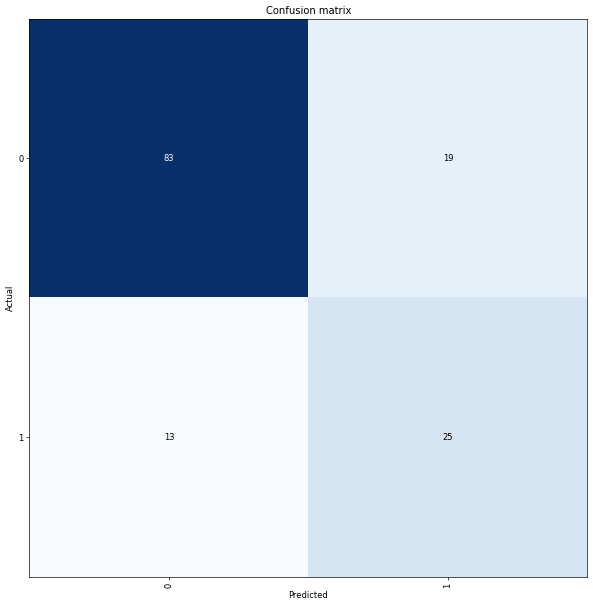

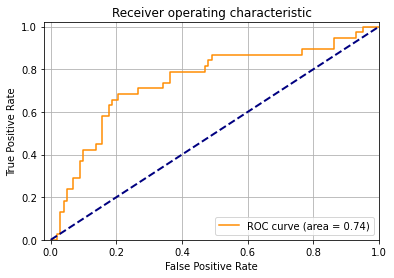

In [84]:
interp = ClassificationInterpretation.from_learner(learn, DatasetType.Test)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)
print("Accuracy: ", round(100 * get_acc(interp), 1), "%")
plot_roc_curve(interp)
cm = interp.confusion_matrix()
precision = cm[0][0] / (cm[0][0] + cm[0][1])
sensitifity = cm[1][1] / (cm[1][0] + cm[1][1])
print(f'precision: {precision}')
print(f'sensitifity: {sensitifity}')

In [16]:
import torch
from fastai.callbacks import *
from fastai.basic_train import LearnerCallback, Learner
from torch.utils.data.sampler import WeightedRandomSampler

class OverSamplingCallback2(LearnerCallback):
    def __init__(self,learn:Learner,weights:torch.Tensor=None):
        super().__init__(learn)
        self.weights = weights

    def on_train_begin(self, **kwargs):
        self.old_dl = self.data.train_dl
        self.labels = self.data.train_dl.y.items
        assert np.issubdtype(self.labels.dtype, np.integer), "Can only oversample integer values"
        _, self.label_counts = np.unique(self.labels,return_counts=True)
        
        redux = int(np.min(self.label_counts) * 0.5)
        self.label_counts[0] += redux
        self.label_counts[1] -= redux
        
        if self.weights is None: self.weights = torch.DoubleTensor((1/self.label_counts)[self.labels])
        self.total_len_oversample = int(self.data.c*np.max(self.label_counts))
        sampler = WeightedRandomSampler(self.weights, self.total_len_oversample)
        self.data.train_dl = self.data.train_dl.new(shuffle=False, sampler=sampler)

    def on_train_end(self, **kwargs):
        "Reset dataloader to its original state"
        self.data.train_dl = self.old_dl

In [17]:
labels = learn.data.train_dl.y.items
_, label_counts = np.unique(labels,return_counts=True)
redux = int(np.min(label_counts) * 0.5)
label_counts[0] = label_counts[0] + redux
label_counts[1] = label_counts[1] - redux
weights = torch.DoubleTensor((1/label_counts)[labels])
total_len_oversample = int(learn.data.c*np.max(label_counts))
total_len_oversample

1114

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


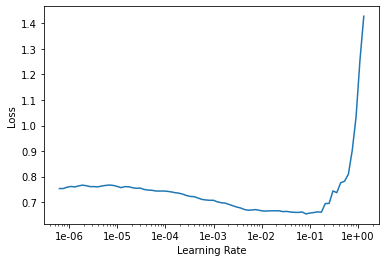

In [18]:
learn = tabular_learner(data, layers=[200,100,100], metrics=accuracy, callback_fns=[OverSamplingCallback])
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(20, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.662666,0.686854,0.521429,00:00
1,0.613258,0.692292,0.564286,00:00
2,0.559939,0.689452,0.607143,00:00
3,0.519864,0.649832,0.578571,00:00
4,0.470695,0.707493,0.592857,00:00
5,0.442328,0.673431,0.635714,00:00
6,0.392566,0.612267,0.664286,00:00
7,0.351575,0.665504,0.700000,00:00
8,0.307994,0.702332,0.700000,00:00
9,0.276305,0.857352,0.650000,00:00


Accuracy:  67.1 %
precision: 0.7156862745098039
sensitifity: 0.5526315789473685


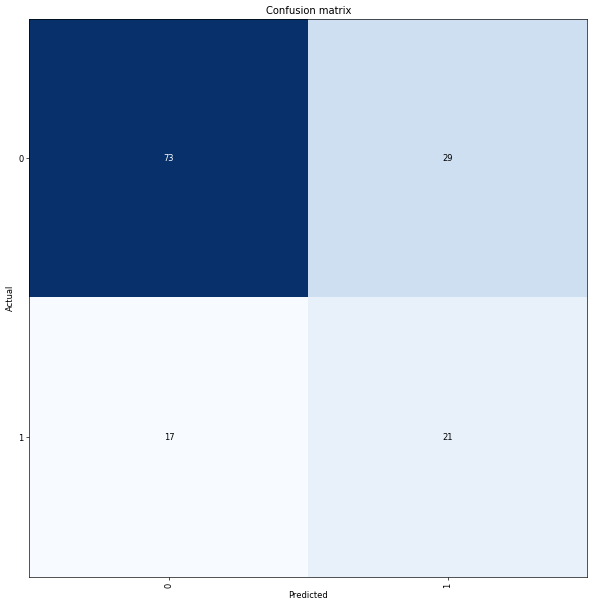

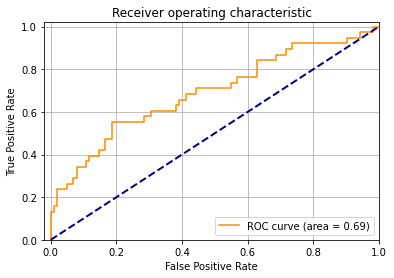

In [21]:
interp = ClassificationInterpretation.from_learner(learn, DatasetType.Test)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)
print("Accuracy: ", round(100 * get_acc(interp), 1), "%")
plot_roc_curve(interp)
cm = interp.confusion_matrix()
precision = cm[0][0] / (cm[0][0] + cm[0][1])
sensitifity = cm[1][1] / (cm[1][0] + cm[1][1])
print(f'precision: {precision}')
print(f'sensitifity: {sensitifity}')

epoch,train_loss,valid_loss,accuracy,time
0,0.327559,0.665193,0.657143,00:00
1,0.318693,0.647908,0.671429,00:00
2,0.328042,0.650556,0.692857,00:00
3,0.324767,0.651129,0.678571,00:00
4,0.315472,0.654528,0.678571,00:00


Accuracy:  77.1 %
precision: 0.803921568627451
sensitifity: 0.6842105263157895


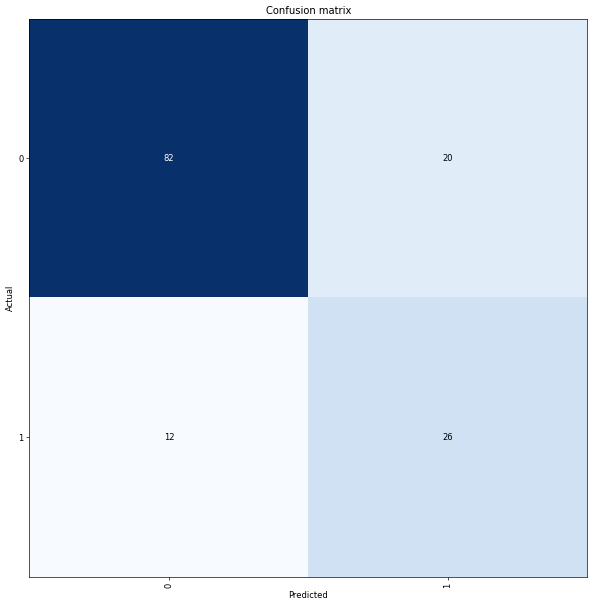

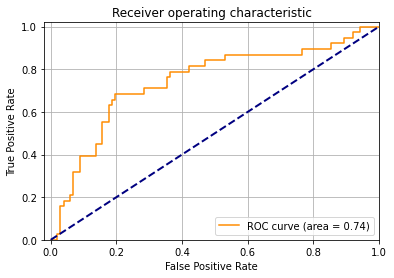

In [90]:
learn.load('best_so_far')
learn.fit_one_cycle(5, max_lr=1e-5)
interp = ClassificationInterpretation.from_learner(learn, DatasetType.Test)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)
print("Accuracy: ", round(100 * get_acc(interp), 1), "%")
plot_roc_curve(interp)
cm = interp.confusion_matrix()
precision = cm[0][0] / (cm[0][0] + cm[0][1])
sensitifity = cm[1][1] / (cm[1][0] + cm[1][1])
print(f'precision: {precision}')
print(f'sensitifity: {sensitifity}')

In [86]:
cm = interp.confusion_matrix()
precision = cm[0][0] / (cm[0][0] + cm[0][1])
sensitifity = cm[1][1] / (cm[1][0] + cm[1][1])
print(f'precision: {precision}')
print(f'sensitifity: {sensitifity}')

precision: 0.8137254901960784
sensitifity: 0.6578947368421053


epoch,train_loss,valid_loss,accuracy,time
0,0.307597,0.629379,0.692857,00:00
1,0.309272,0.649205,0.692857,00:00
2,0.308059,0.666303,0.678571,00:00
3,0.300824,0.649425,0.678571,00:00
4,0.290862,0.647274,0.664286,00:00


Accuracy:  74.3 %
precision: 0.7941176470588235
sensitifity: 0.6052631578947368


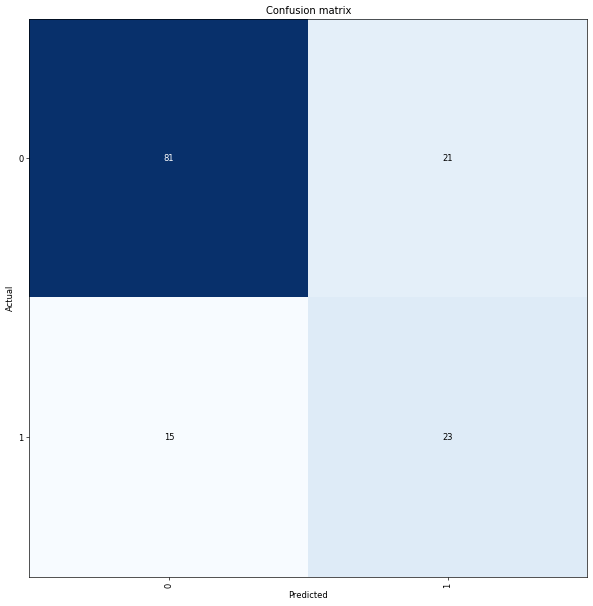

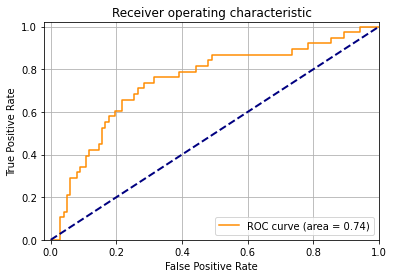

In [87]:
learn.fit_one_cycle(5, max_lr=1e-5)
interp = ClassificationInterpretation.from_learner(learn, DatasetType.Test)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)
print("Accuracy: ", round(100 * get_acc(interp), 1), "%")
plot_roc_curve(interp)
cm = interp.confusion_matrix()
precision = cm[0][0] / (cm[0][0] + cm[0][1])
sensitifity = cm[1][1] / (cm[1][0] + cm[1][1])
print(f'precision: {precision}')
print(f'sensitifity: {sensitifity}')

In [91]:
#learn.save('best_so_far_2')

In [107]:
learn.load('best_so_far_2')
interp = ClassificationInterpretation.from_learner(learn, DatasetType.Test)
#interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)
print("Accuracy: ", round(100 * get_acc(interp), 1), "%")
#plot_roc_curve(interp)
cm = interp.confusion_matrix()
precision = cm[0][0] / (cm[0][0] + cm[0][1])
sensitifity = cm[1][1] / (cm[1][0] + cm[1][1])
print(f'precision: {precision}')
print(f'sensitifity: {sensitifity}')

Accuracy:  77.1 %
precision: 0.803921568627451
sensitifity: 0.6842105263157895


epoch,train_loss,valid_loss,accuracy,time
0,0.321795,0.639511,0.685714,00:00
1,0.314363,0.634351,0.678571,00:00
2,0.318062,0.639741,0.678571,00:00
3,0.320247,0.638256,0.692857,00:00
4,0.307314,0.632036,0.685714,00:00


Accuracy:  77.1 %
precision: 0.8137254901960784
sensitifity: 0.6578947368421053


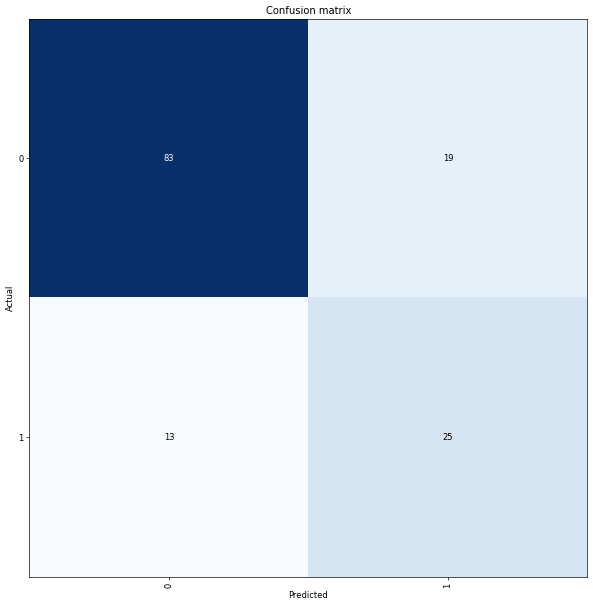

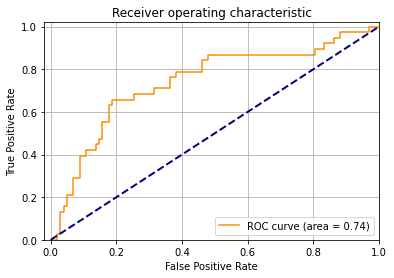

In [105]:
learn.fit_one_cycle(5, max_lr=1e-5)
interp = ClassificationInterpretation.from_learner(learn, DatasetType.Test)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)
print("Accuracy: ", round(100 * get_acc(interp), 1), "%")
plot_roc_curve(interp)
cm = interp.confusion_matrix()
precision = cm[0][0] / (cm[0][0] + cm[0][1])
sensitifity = cm[1][1] / (cm[1][0] + cm[1][1])
print(f'precision: {precision}')
print(f'sensitifity: {sensitifity}')

Accuracy: 0.7428571428571429
AUC: 0.7391640866873065


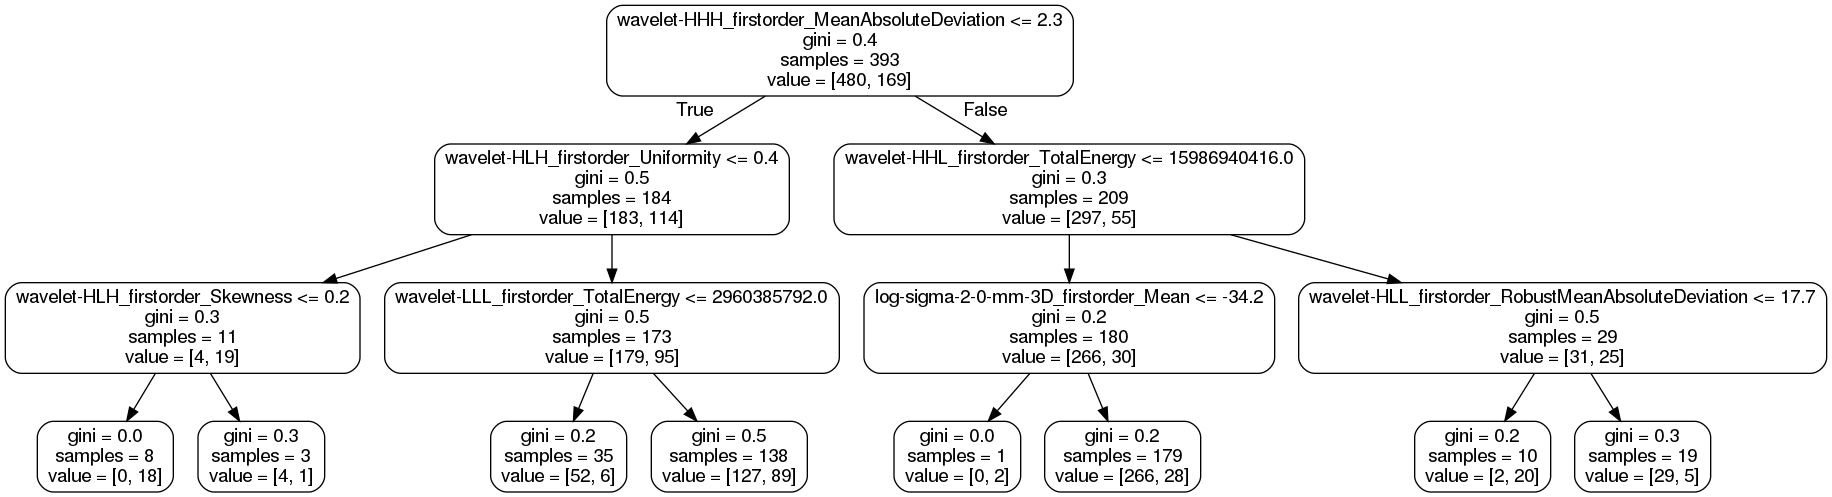

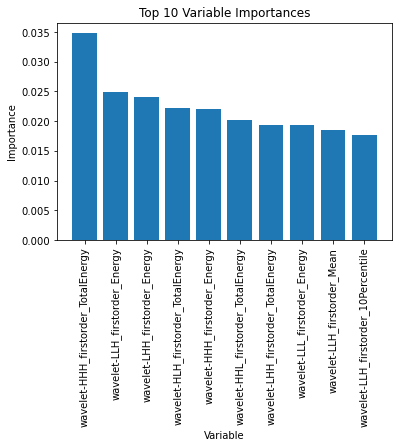

In [19]:
import pydotplus

features = pd.get_dummies(df_all)
label = np.array(features[DEP_KEY])
features= features.drop(DEP_KEY, axis = 1)
feature_list = list(features.columns)
features = np.array(features)

x = features[:trainlen]
y = label[:trainlen]

x_test = features[trainlen::]
y_test = label[trainlen::]

lim = 10
clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=1)

# Train Classifier
clf.fit(x, y)

# Get accuracy
y_pred = clf.predict(x_test)
p_pred = clf.predict_proba(x_test)[:, 1]
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("AUC:", metrics.roc_auc_score(y_test, p_pred))

# Analyse features (with lim)
importances = list(clf.feature_importances_)
x_values = list(range(len(importances)))
imp = importances
f_list = feature_list
sort_ind = np.flip(np.argsort(imp, ))
plt.bar(x_values[:lim], [imp[sort] for sort in sort_ind[:lim]], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values[:lim], [f_list[sort] for sort in sort_ind[:lim]], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title(f'Top {lim} Variable Importances');

# Make graph
tree = clf.estimators_[10] # Import tools needed for visualization
export_graphviz(tree, out_file = 'tree.dot', feature_names=feature_list, rounded=True, precision=1)
(graph, ) = pydot.graph_from_dot_file('tree.dot') # Write graph to a png file
Image(graph.create_png())

<AxesSubplot:>

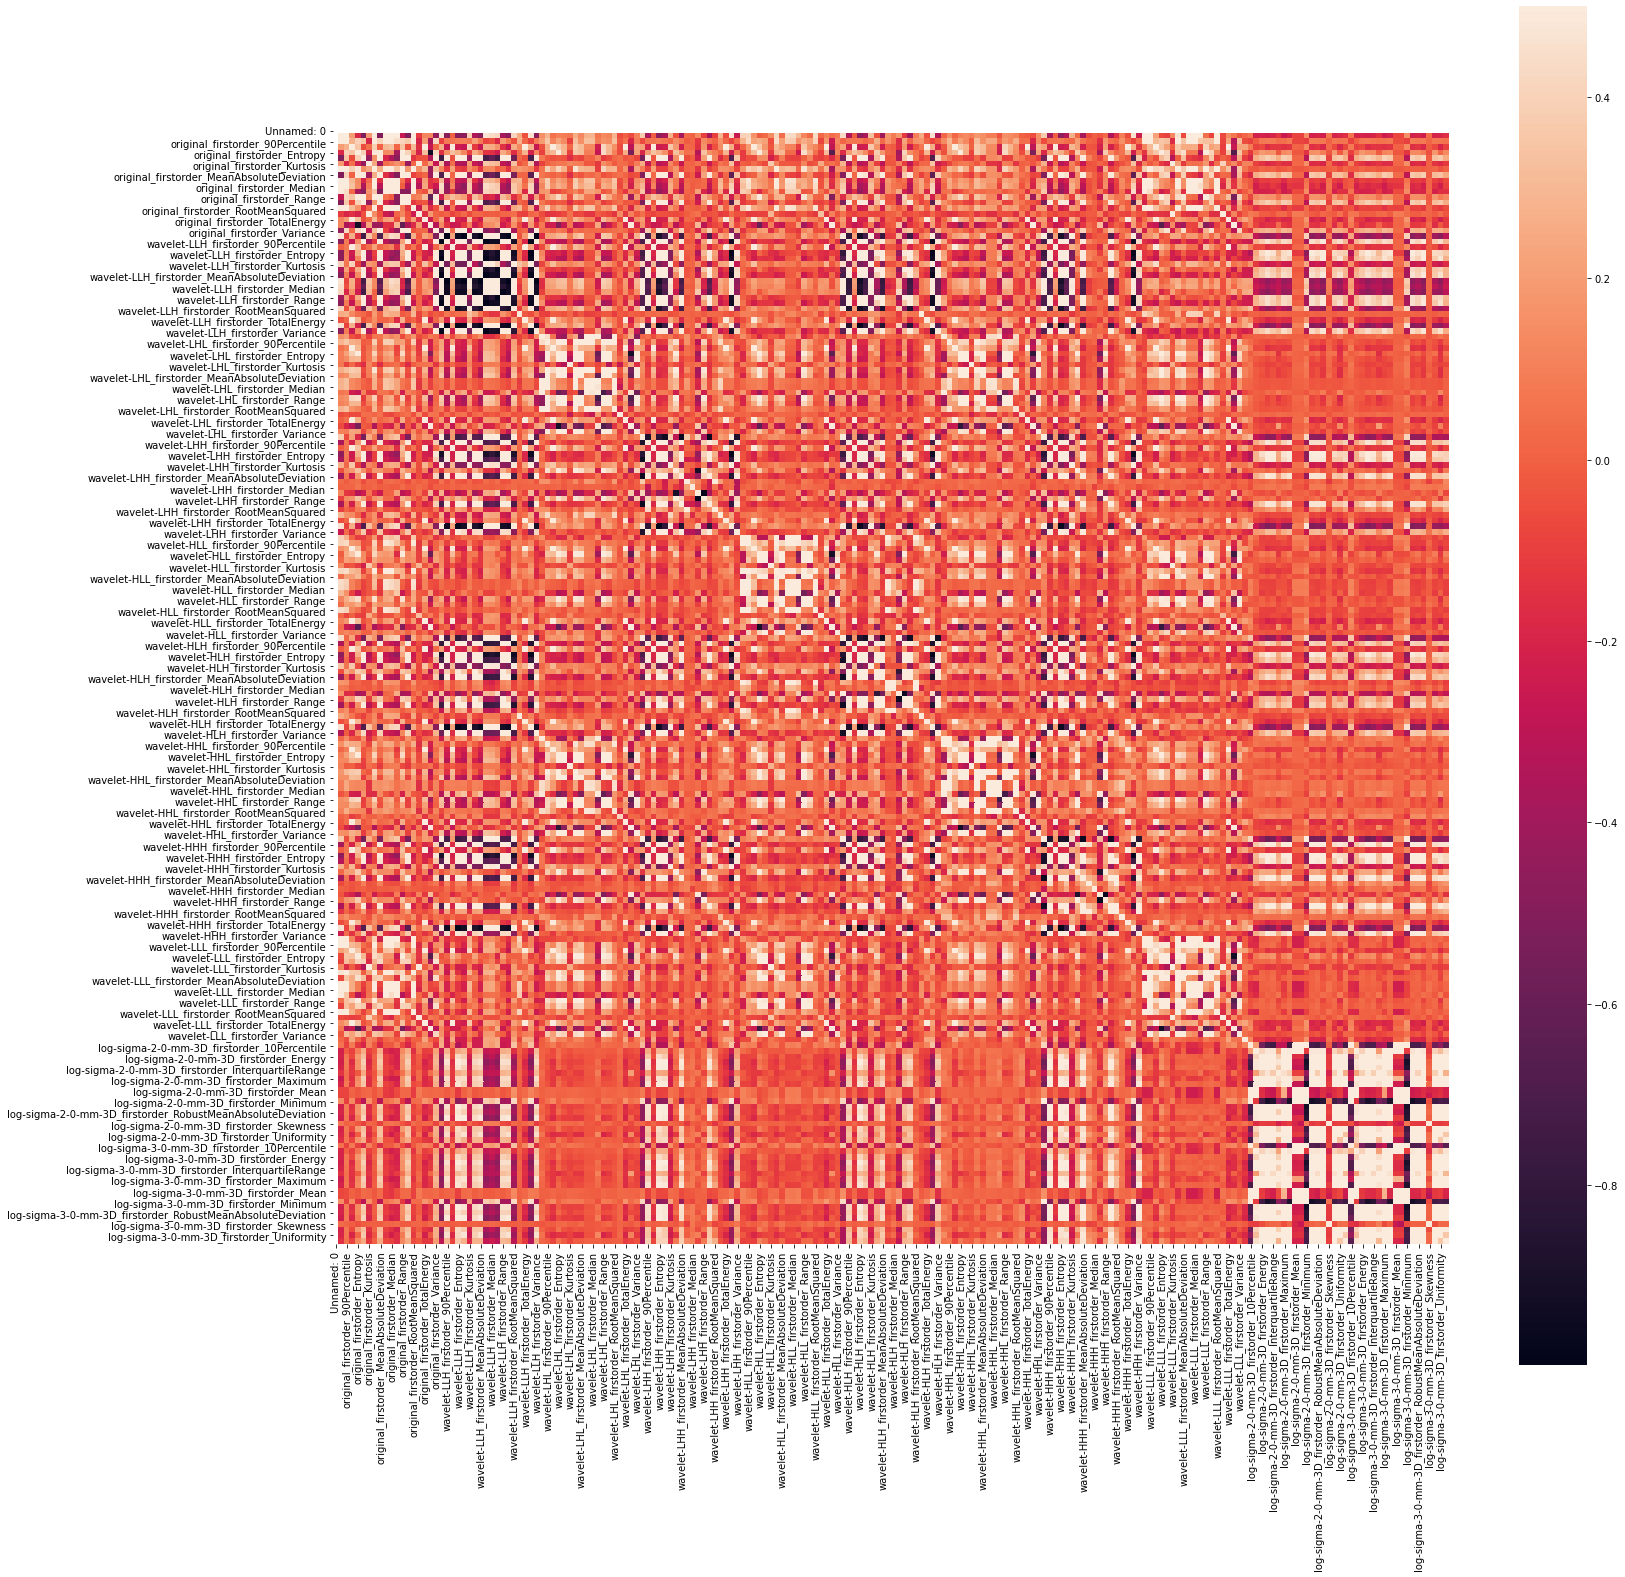

In [109]:
import seaborn as sns

train = pd.read_csv(f'{PATH}/train.csv')
train = train.fillna(0).drop(columns=['label2'])
corr = train.corr()

# Set up the matplotlib figure, make it big!
f, ax = plt.subplots(figsize=(25, 25))

# Draw the heatmap using seaborn
sns.heatmap(corr, vmax=.5, square=True)

In [110]:
corr

,Unnamed: 0,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,...,log-sigma-3-0-mm-3D_firstorder_Mean,log-sigma-3-0-mm-3D_firstorder_Median,log-sigma-3-0-mm-3D_firstorder_Minimum,log-sigma-3-0-mm-3D_firstorder_Range,log-sigma-3-0-mm-3D_firstorder_RobustMeanAbsoluteDeviation,log-sigma-3-0-mm-3D_firstorder_RootMeanSquared,log-sigma-3-0-mm-3D_firstorder_Skewness,log-sigma-3-0-mm-3D_firstorder_TotalEnergy,log-sigma-3-0-mm-3D_firstorder_Uniformity,log-sigma-3-0-mm-3D_firstorder_Variance
Unnamed: 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
original_firstorder_10Percentile,NaN,1.000000,0.555459,0.197656,-0.181535,-0.515640,0.188881,0.499850,-0.507097,0.903350,...,-0.076407,-0.078691,0.151595,-0.217469,-0.200867,-0.227069,0.032486,-0.203631,-0.196576,-0.153879
original_firstorder_90Percentile,NaN,0.555459,1.000000,0.273418,0.399264,0.345356,-0.193313,0.811926,0.405972,0.823248,...,-0.061157,-0.062030,-0.097274,0.087041,0.073454,0.079310,0.014598,0.077114,0.066806,0.054798
original_firstorder_Energy,NaN,0.197656,0.273418,1.000000,0.352681,-0.057411,0.046283,0.386885,0.006237,0.304544,...,0.004085,0.005016,0.136929,-0.160537,-0.137774,-0.189098,-0.008872,-0.069204,-0.190910,-0.091129
original_firstorder_Entropy,NaN,-0.181535,0.399264,0.352681,1.000000,0.394228,-0.219791,0.479557,0.484033,0.135998,...,-0.029363,-0.024452,-0.127180,0.133928,0.132379,0.090426,-0.048430,0.183627,0.017907,0.135658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
log-sigma-3-0-mm-3D_firstorder_RootMeanSquared,NaN,-0.227069,0.079310,-0.189098,0.090426,0.404581,-0.191845,-0.019562,0.381172,-0.136761,...,-0.108165,-0.106529,-0.845613,0.954476,0.840658,1.000000,-0.000943,0.760549,0.913704,0.620365
log-sigma-3-0-mm-3D_firstorder_Skewness,NaN,0.032486,0.014598,-0.008872,-0.048430,-0.013108,0.000614,0.000989,-0.013801,0.016806,...,-0.262700,-0.335646,-0.062940,0.005953,0.004160,-0.000943,1.000000,-0.056560,0.031037,0.025186
log-sigma-3-0-mm-3D_firstorder_TotalEnergy,NaN,-0.203631,0.077114,-0.069204,0.183627,0.325299,-0.143288,0.016922,0.317557,-0.100231,...,-0.123206,-0.115061,-0.745708,0.830656,0.751249,0.760549,-0.056560,1.000000,0.597754,0.608320
log-sigma-3-0-mm-3D_firstorder_Uniformity,NaN,-0.196576,0.066806,-0.190910,0.017907,0.367614,-0.176571,-0.035546,0.338611,-0.132788,...,-0.108070,-0.105001,-0.704528,0.790027,0.592128,0.913704,0.031037,0.597754,1.000000,0.357320


In [111]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Choose a subset of features for clustering
dd = train.iloc[:,1:50]

# sns.clustermap(d, linewidths=.5, figsize=(13,13))
m = train.to_numpy()

Z = linkage(m,'ward')

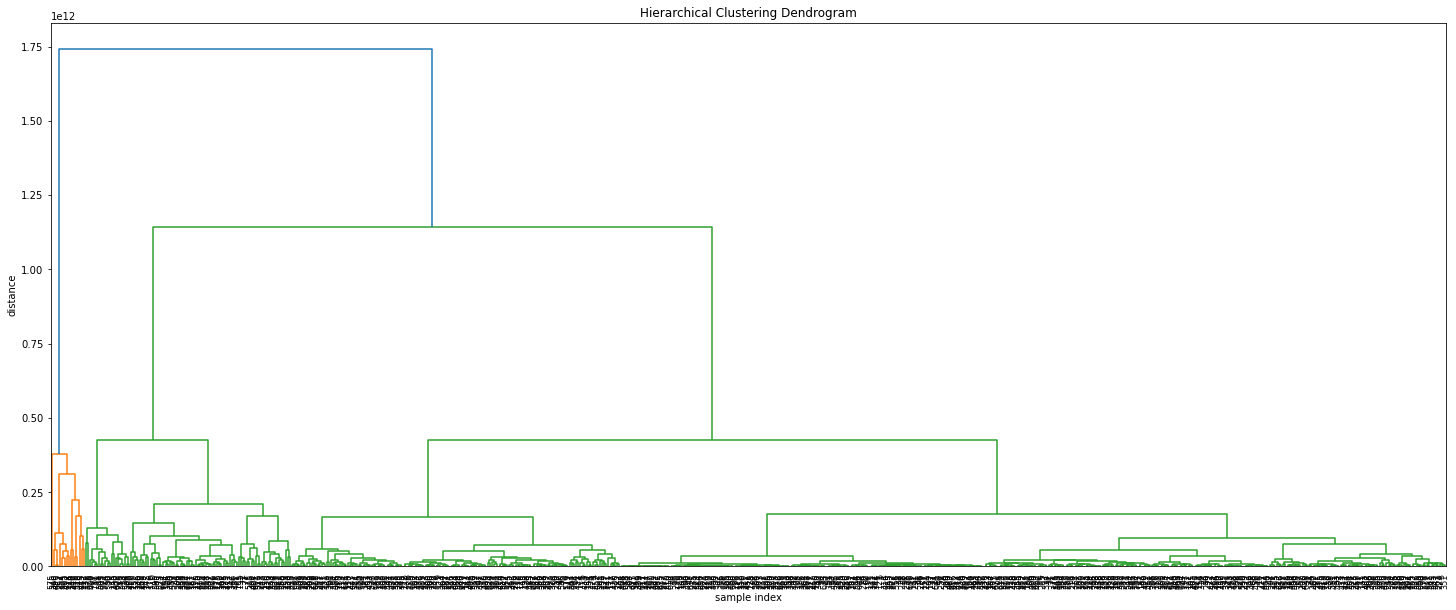

In [112]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [46]:
train.iloc[:10, :]

,Unnamed: 0,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,...,log-sigma-3-0-mm-3D_firstorder_Mean,log-sigma-3-0-mm-3D_firstorder_Median,log-sigma-3-0-mm-3D_firstorder_Minimum,log-sigma-3-0-mm-3D_firstorder_Range,log-sigma-3-0-mm-3D_firstorder_RobustMeanAbsoluteDeviation,log-sigma-3-0-mm-3D_firstorder_RootMeanSquared,log-sigma-3-0-mm-3D_firstorder_Skewness,log-sigma-3-0-mm-3D_firstorder_TotalEnergy,log-sigma-3-0-mm-3D_firstorder_Uniformity,log-sigma-3-0-mm-3D_firstorder_Variance
0,0,15.500020,58.765416,1.308054e+10,4.032506,21.951561,8.831832,174.001975,17.160024,38.396903,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,47.467195,66.612836,4.626589e+08,2.697371,10.327073,5.225828,77.232934,6.350329,56.910082,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,-24.941871,42.195378,1.114753e+10,4.553707,35.356870,7.945965,116.520749,25.008526,4.948465,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2.175243,58.478122,3.331790e+09,3.858980,17.818996,5.631246,88.865517,15.561807,22.142780,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,6.115728,66.987773,6.860790e+09,4.145085,28.682225,18.094700,261.096939,20.500603,33.386308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,3.248862,94.196511,6.922848e+09,4.746428,40.594858,3.110607,161.483655,26.454921,53.701959,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0,53.782671,100.948567,4.121877e+08,3.398714,26.611157,2.250245,108.549202,14.348240,71.777872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0,-61.899994,-38.974993,7.719381e+08,2.804734,13.048736,3.230863,-9.451346,7.123227,-48.963136,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,41.185853,125.092341,2.968635e+09,4.321586,49.334661,2.074831,141.016487,27.372631,73.861938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0,-60.601783,45.957608,2.091248e+09,4.630261,86.117581,2.183248,129.739071,42.783924,-12.701636,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


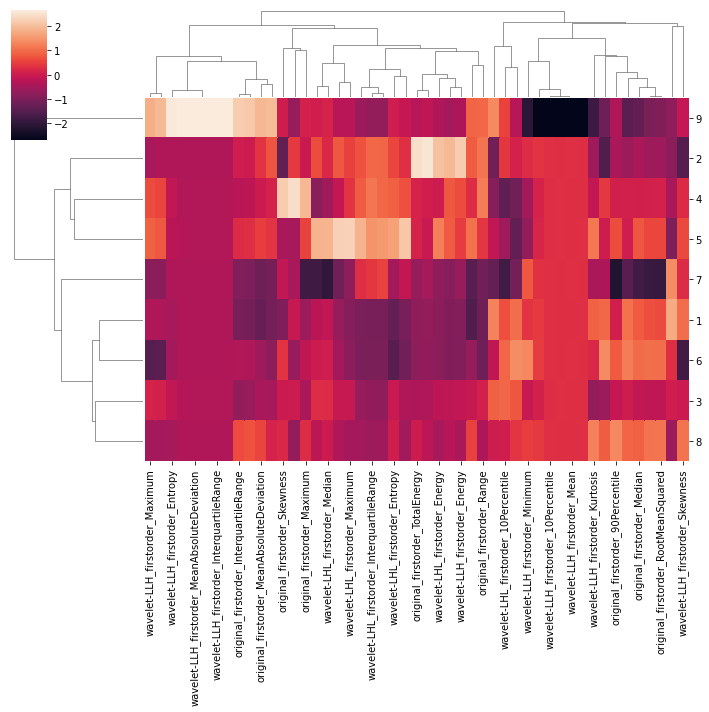

<Figure size 1080x1080 with 0 Axes>

In [135]:
pp = sns.clustermap(train.iloc[1:10, 1:50], col_cluster=True, z_score=1)
plt.figure(figsize=(15, 15))
_ = plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()

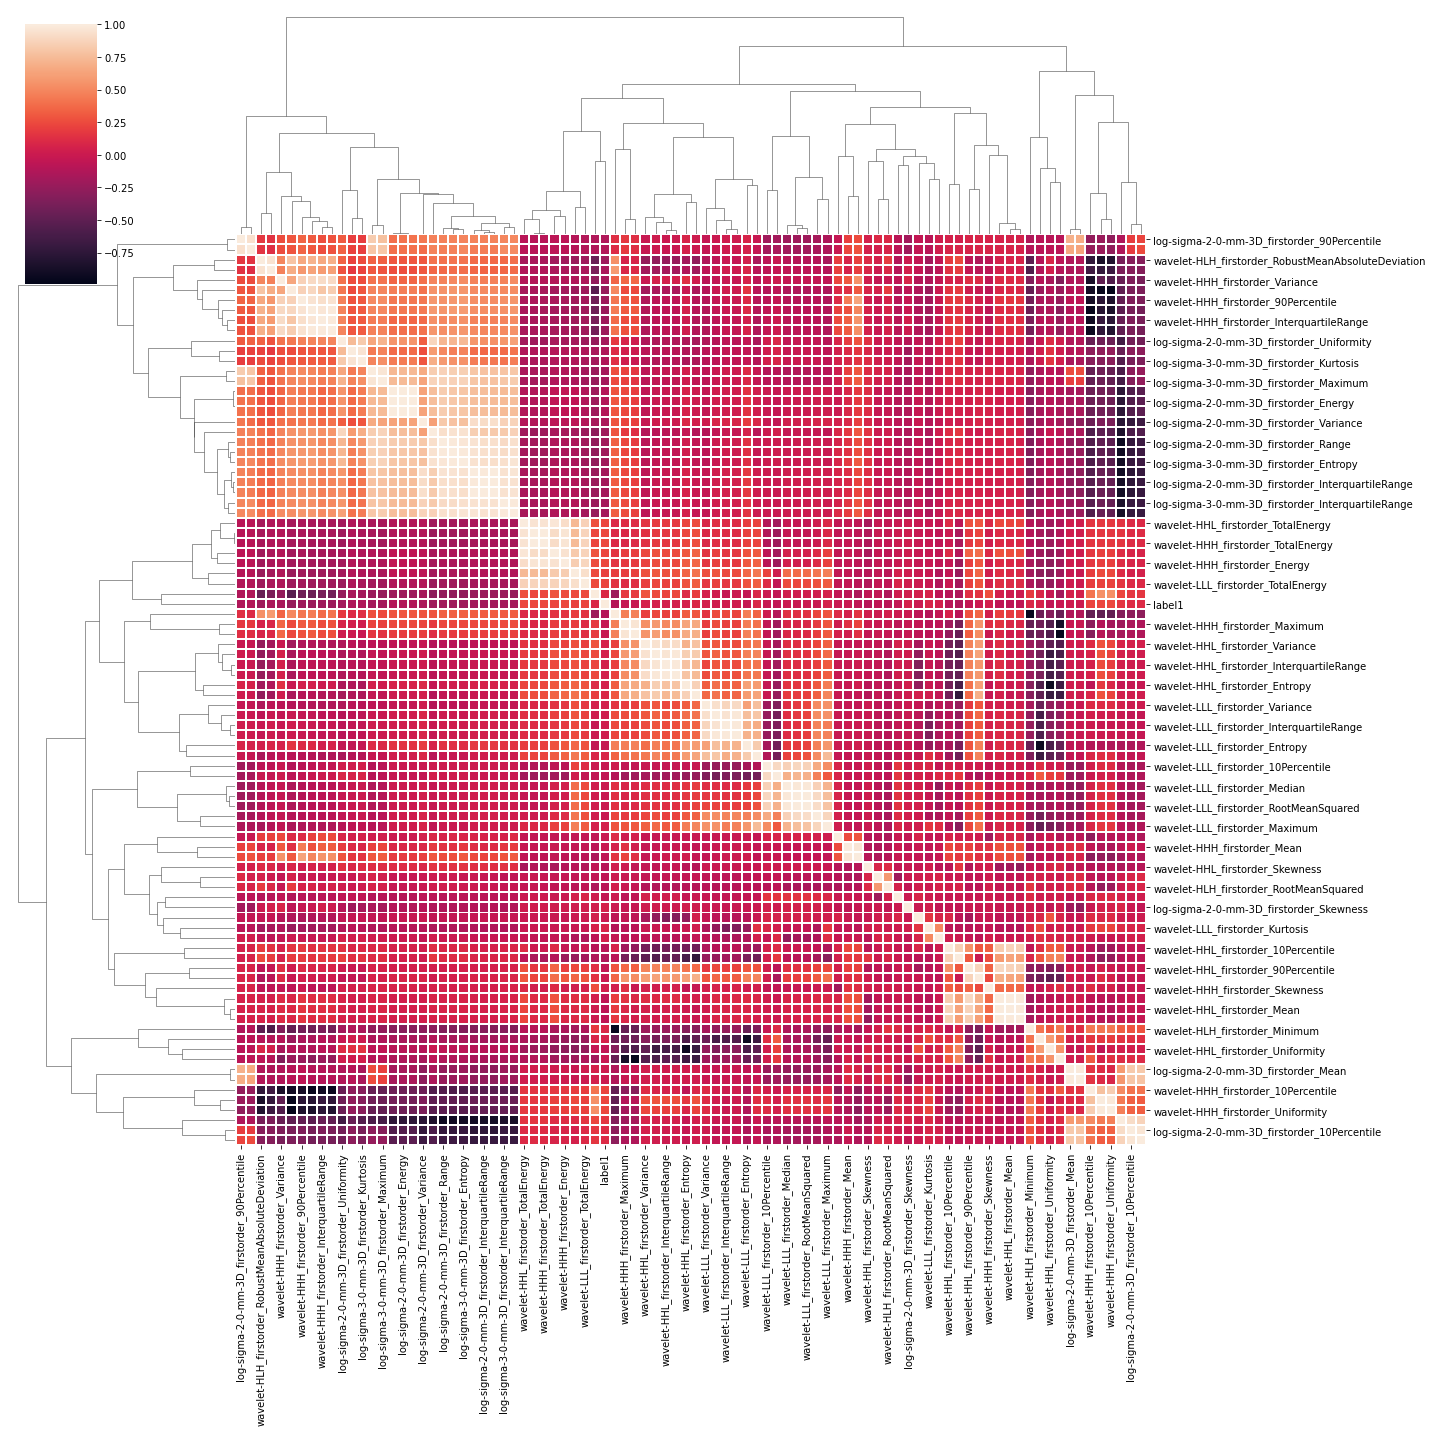

In [133]:
# Choose a subset of features for clustering
dd = train.iloc[:,100:-10]

pp = sns.clustermap(dd.corr(), linewidths=1, figsize=(20,20))
_ = plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)

plt.show()

In [41]:
dd

,Unnamed: 0,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,...,log-sigma-3-0-mm-3D_firstorder_Mean,log-sigma-3-0-mm-3D_firstorder_Median,log-sigma-3-0-mm-3D_firstorder_Minimum,log-sigma-3-0-mm-3D_firstorder_Range,log-sigma-3-0-mm-3D_firstorder_RobustMeanAbsoluteDeviation,log-sigma-3-0-mm-3D_firstorder_RootMeanSquared,log-sigma-3-0-mm-3D_firstorder_Skewness,log-sigma-3-0-mm-3D_firstorder_TotalEnergy,log-sigma-3-0-mm-3D_firstorder_Uniformity,log-sigma-3-0-mm-3D_firstorder_Variance
0,0,15.500020,58.765416,1.308054e+10,4.032506,21.951561,8.831832,174.001975,17.160024,38.396903,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
1,0,47.467195,66.612836,4.626589e+08,2.697371,10.327073,5.225828,77.232934,6.350329,56.910082,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
2,0,-24.941871,42.195378,1.114753e+10,4.553707,35.356870,7.945965,116.520749,25.008526,4.948465,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
3,0,2.175243,58.478122,3.331790e+09,3.858980,17.818996,5.631246,88.865517,15.561807,22.142780,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
4,0,6.115728,66.987773,6.860790e+09,4.145085,28.682225,18.094700,261.096939,20.500603,33.386308,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,0,-111.324392,-41.406304,1.353018e+09,4.266207,48.006174,2.146795,21.521846,23.274203,-79.206988,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
645,0,-85.248737,43.540813,8.701807e+08,4.157283,108.149509,1.648891,75.650030,48.180472,-34.028466,...,-8.574611,-9.727719,-40.041046,65.004835,10.527368,291.805497,0.095653,2.014660e+09,0.098147,221.690817
646,0,-20.177892,182.176873,2.920467e+09,4.323047,180.270505,1.120656,201.898470,87.480904,73.594438,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
647,0,-68.948664,45.751290,2.431034e+09,4.350454,80.332235,1.898783,77.730174,40.565290,-26.627306,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000


In [37]:
dd.corr

<bound method DataFrame.corr of      original_firstorder_10Percentile  original_firstorder_90Percentile  \
0                           15.500020                         58.765416   
1                           47.467195                         66.612836   
2                          -24.941871                         42.195378   
3                            2.175243                         58.478122   
4                            6.115728                         66.987773   
..                                ...                               ...   
644                       -111.324392                        -41.406304   
645                        -85.248737                         43.540813   
646                        -20.177892                        182.176873   
647                        -68.948664                         45.751290   
648                        -44.441238                         94.316444   

     original_firstorder_Energy  original_firstorder_Entropy  \
0  